# 유사 음원 찾기
### 데이터 구성
### Score 산출 기준 설정
### 음원 특성 추출 및 유사도 비교<br/>
* ### 음원 특성 추출<br/>
1차) Tempo 1개, Chroma 72개<br/>
2차) (추가 특성)<br/>

* ### 유사도 비교<br/>
1차) 유클리드 거리, 코사인 유사도, 피어슨 유사도<br/>
2차) K-Means, DBSCAN<br/>
3차) Mel Spectrogram 기반 딥러닝

### Score 측정

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

warnings.filterwarnings(action='ignore')

In [ ]:
DIR_PATH = "/content/drive/MyDrive/ds_study/DL_project2/"

SAMPLING_RATE = 44100

SAMPLE_MUSIC = 50 # 비교용 샘플 Music 랜덤 추출 개수

START_INDEX = 0 # 데이터프레임에서 조회할 음원 index 기본 범위 설정
END_INDEX = 9999 # 데이터프레임에서 조회할 음원 index 기본 범위 설정

#### mp3파일 경로 데이터프레임 생성

In [ ]:
# music_paths = glob.glob(DIR_PATH + "data/*.mp3")
# music_paths[:5]

In [ ]:
# total_music_paths = pd.DataFrame(music_paths, columns=["Path"])
# total_music_paths.head()

In [ ]:
# total_music_paths.to_csv(DIR_PATH + 'music_paths.csv', index=False) # csv 파일로 저장

In [ ]:
total_music_paths = pd.read_csv(DIR_PATH + 'music_paths.csv')
total_music_paths.head()

,Path
0,/content/drive/MyDrive/ds_study/DL_project2/da...
1,/content/drive/MyDrive/ds_study/DL_project2/da...
2,/content/drive/MyDrive/ds_study/DL_project2/da...
3,/content/drive/MyDrive/ds_study/DL_project2/da...
4,/content/drive/MyDrive/ds_study/DL_project2/da...


In [ ]:
total_music_paths.shape

(2341, 1)

# 음원 특성 관련 Chroma 시각화 및 검토

In [ ]:
import librosa
import librosa.display
import IPython.display as ipd

In [ ]:
# chromagram 시각화 함수 정의 => 'stft', 'cqt', 'cens' 옵션별 출력
def show_chromagram(music, sr, type='stft'):
  if type == 'cqt':
    chroma = librosa.feature.chroma_cqt(music, sr)
  elif type == 'cens':
    chroma = librosa.feature.chroma_cens(music, sr)
  elif type == 'stft':
    chroma = librosa.feature.chroma_stft(music, sr)
  else:
    print('type error')
    return

  seconds = len(music)/SAMPLING_RATE

  plt.figure(figsize=(15,5))
  librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma')
  plt.colorbar()
  plt.tight_layout()
  plt.xlabel('time')
  plt.ylabel('pitch class')
  plt.xticks(np.arange(0, seconds, seconds//10)) # 좌표간격 설정
  plt.show()

In [ ]:
# 테스트용 음원 load
music, sr = librosa.load(total_music_paths.loc[0, 'Path'], sr=SAMPLING_RATE, duration=None)

#### chroma_stft

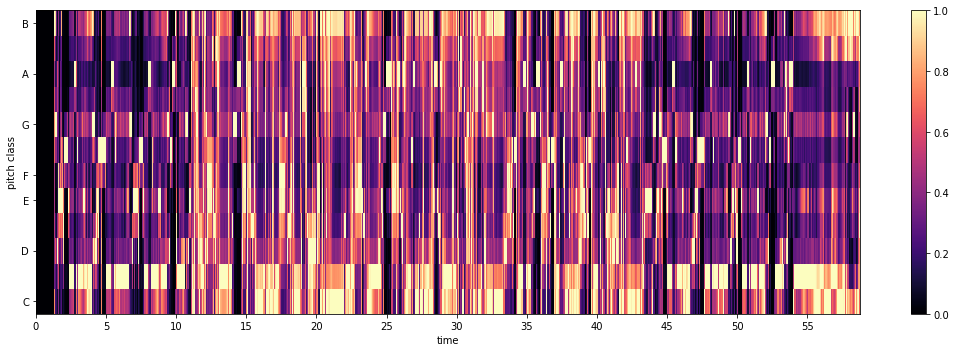

In [ ]:
show_chromagram(music, sr, 'stft')

#### chroma_cqt

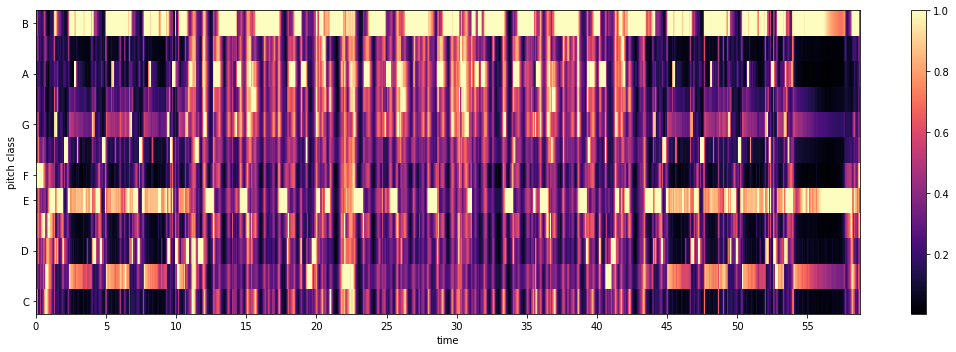

In [ ]:
show_chromagram(music, sr, 'cqt')

#### chroma_cens

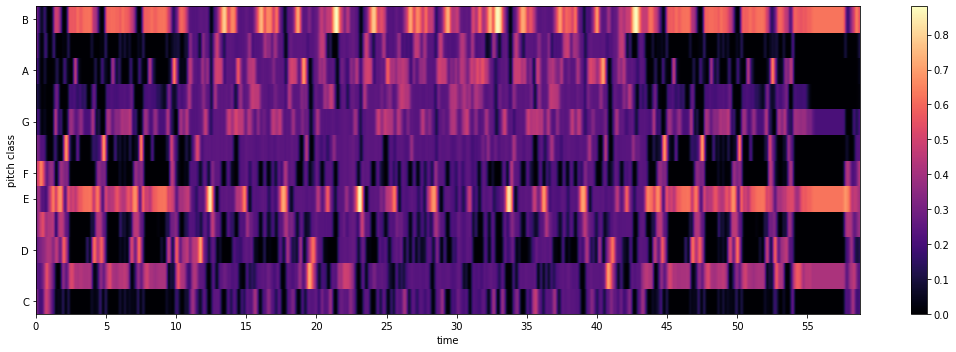

In [ ]:
show_chromagram(music, sr, 'cens')

# 데이터 구성

In [ ]:
# 유사곡 위주의 Test 데이터 파일정보 생성
test_data = pd.read_excel(DIR_PATH + 'test_data/test_data_list.xlsx', index_col=0)
test_data

,Music,Path
1,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...
2,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...
3,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...
4,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...
5,요시마타 료 - Resolver,/content/drive/MyDrive/ds_study/DL_project2/te...
6,FTISLAND - 사랑앓이,/content/drive/MyDrive/ds_study/DL_project2/te...
7,TLC - No Scrubs,/content/drive/MyDrive/ds_study/DL_project2/te...
8,Ed Sheeran - Shape of you,/content/drive/MyDrive/ds_study/DL_project2/te...
9,Harold Faltermeyer - Axel F,/content/drive/MyDrive/ds_study/DL_project2/te...
10,싸이 - 챔피언,/content/drive/MyDrive/ds_study/DL_project2/te...


In [ ]:
# 샘플 Music 랜덤 추출
random.seed(42)

sample_index = random.sample(range(len(total_music_paths)), SAMPLE_MUSIC) # SAMPLE_MUSIC : 추출 개수
sample_index.sort()

sample_music = total_music_paths.loc[sample_index, :]
sample_music["Music"] = [f'Music_{idx}' for idx in sample_music.index]
sample_music = sample_music[['Music', 'Path']]
sample_music.head()

,Music,Path
26,Music_26,/content/drive/MyDrive/ds_study/DL_project2/da...
102,Music_102,/content/drive/MyDrive/ds_study/DL_project2/da...
108,Music_108,/content/drive/MyDrive/ds_study/DL_project2/da...
122,Music_122,/content/drive/MyDrive/ds_study/DL_project2/da...
130,Music_130,/content/drive/MyDrive/ds_study/DL_project2/da...


#### Total 데이터프레임 생성 => "df_total_v0"

In [ ]:
# Test 데이터 및 샘플 Music 합치기 => Total 데이터 "df_total_v0" 생성
df_total_v0 = pd.concat([test_data, sample_music])
df_total_v0.reset_index(drop=True, inplace=True)
df_total_v0.head()

,Music,Path
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...
4,요시마타 료 - Resolver,/content/drive/MyDrive/ds_study/DL_project2/te...


In [ ]:
df_total_v0.tail()

,Music,Path
59,Music_2196,/content/drive/MyDrive/ds_study/DL_project2/da...
60,Music_2232,/content/drive/MyDrive/ds_study/DL_project2/da...
61,Music_2233,/content/drive/MyDrive/ds_study/DL_project2/da...
62,Music_2261,/content/drive/MyDrive/ds_study/DL_project2/da...
63,Music_2298,/content/drive/MyDrive/ds_study/DL_project2/da...


# 음원 특성 추출 및 유사도 비교(1차)
* 추출 특성 : Tempo 1개, Chroma 72개
* 유사도 기준 : 유클리드 거리, 코사인 유사도, 피어슨 유사도

## 음원 특성 추출

In [ ]:
# 음원 특성 추출 함수 정의(v1)
def get_features_v1(df, duration=None, offset=0.0, start_idx=START_INDEX, end_idx=END_INDEX):
  df_copy = df.copy() # 데이터프레임 복사본 생성

  for idx, row in tqdm(df_copy.iterrows()):
    # index 범위 확인
    if idx < start_idx or idx > end_idx:
      continue

    # 음원 load
    music_path = row['Path']
    music, sr = librosa.load(music_path, sr=SAMPLING_RATE, duration=duration, offset=offset) # 옵션값 기준 구간 설정

    # 템포 저장
    df_copy.loc[idx, 'Tempo'] = librosa.beat.tempo(music, sr=sr)

    # # zero_crossings 저장 => 적용 제외
    # df_copy.loc[idx, 'Zero_crossings'] = sum(librosa.zero_crossings(music, pad=False))

    # chroma_stft 12음계별 평균 및 분산 산출 후 저장
    chroma_stft_raw = librosa.feature.chroma_stft(music, sr)
    for i, values in enumerate(chroma_stft_raw):
      df_copy.loc[idx, f'Chroma_stft{i+1}_mean'] = values.mean() # 평균
      df_copy.loc[idx, f'Chroma_stft{i+1}_var'] = values.var() # 분산
    
    # chroma_cqt 12음계별 평균 및 분산 산출 후 저장
    chroma_cqt_raw = librosa.feature.chroma_cqt(music, sr)
    for i, values in enumerate(chroma_cqt_raw):
      df_copy.loc[idx, f'Chroma_cqt{i+1}_mean'] = values.mean() # 평균
      df_copy.loc[idx, f'Chroma_cqt{i+1}_var'] = values.var() # 분산
    
    # chroma_cens 12음계별 평균 및 분산 산출 후 저장
    chroma_cens_raw = librosa.feature.chroma_cens(music, sr)
    for i, values in enumerate(chroma_cens_raw):
      df_copy.loc[idx, f'Chroma_cens{i+1}_mean'] = values.mean() # 평균
      df_copy.loc[idx, f'Chroma_cens{i+1}_var'] = values.var() # 분산
  
  return df_copy

#### 음원 특성 추출 결과 저장 => "df_total_v1"

In [ ]:
df_total_v1 = get_features_v1(df_total_v0)

0it [00:00, ?it/s]

In [ ]:
df_total_v1.head()

,Music,Path,Tempo,Chroma_stft1_mean,Chroma_stft1_var,Chroma_stft2_mean,Chroma_stft2_var,Chroma_stft3_mean,Chroma_stft3_var,Chroma_stft4_mean,Chroma_stft4_var,Chroma_stft5_mean,Chroma_stft5_var,Chroma_stft6_mean,Chroma_stft6_var,Chroma_stft7_mean,Chroma_stft7_var,Chroma_stft8_mean,Chroma_stft8_var,Chroma_stft9_mean,Chroma_stft9_var,Chroma_stft10_mean,Chroma_stft10_var,Chroma_stft11_mean,Chroma_stft11_var,Chroma_stft12_mean,Chroma_stft12_var,Chroma_cqt1_mean,Chroma_cqt1_var,Chroma_cqt2_mean,Chroma_cqt2_var,Chroma_cqt3_mean,Chroma_cqt3_var,Chroma_cqt4_mean,Chroma_cqt4_var,Chroma_cqt5_mean,Chroma_cqt5_var,Chroma_cqt6_mean,Chroma_cqt6_var,Chroma_cqt7_mean,Chroma_cqt7_var,Chroma_cqt8_mean,Chroma_cqt8_var,Chroma_cqt9_mean,Chroma_cqt9_var,Chroma_cqt10_mean,Chroma_cqt10_var,Chroma_cqt11_mean,Chroma_cqt11_var,Chroma_cqt12_mean,Chroma_cqt12_var,Chroma_cens1_mean,Chroma_cens1_var,Chroma_cens2_mean,Chroma_cens2_var,Chroma_cens3_mean,Chroma_cens3_var,Chroma_cens4_mean,Chroma_cens4_var,Chroma_cens5_mean,Chroma_cens5_var,Chroma_cens6_mean,Chroma_cens6_var,Chroma_cens7_mean,Chroma_cens7_var,Chroma_cens8_mean,Chroma_cens8_var,Chroma_cens9_mean,Chroma_cens9_var,Chroma_cens10_mean,Chroma_cens10_var,Chroma_cens11_mean,Chroma_cens11_var,Chroma_cens12_mean,Chroma_cens12_var
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,93.963068,0.455629,0.091857,0.421035,0.069740,0.501934,0.095546,0.471786,0.095901,0.422948,0.077418,0.519904,0.103906,0.424737,0.072491,0.397458,0.079420,0.396315,0.075201,0.480287,0.078926,0.610189,0.101571,0.466969,0.066534,0.515204,0.076764,0.401413,0.048684,0.582404,0.081058,0.554251,0.088089,0.380095,0.043671,0.553827,0.073857,0.381136,0.041231,0.499511,0.069588,0.420015,0.065681,0.463250,0.049916,0.582027,0.075694,0.376777,0.040850,0.281621,0.018584,0.200288,0.009001,0.321092,0.023422,0.302838,0.029530,0.186214,0.007784,0.312777,0.018942,0.197135,0.006399,0.271000,0.017986,0.210762,0.018934,0.254793,0.009485,0.330936,0.018623,0.189543,0.007481
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,95.703125,0.385404,0.101627,0.345018,0.084830,0.338347,0.083915,0.373243,0.105011,0.357092,0.093823,0.320674,0.084240,0.305181,0.071329,0.380741,0.087481,0.513290,0.117372,0.490511,0.097662,0.467087,0.107167,0.419564,0.096385,0.561075,0.121495,0.531338,0.120026,0.430538,0.078338,0.473896,0.086555,0.339087,0.047981,0.350441,0.057806,0.322761,0.047782,0.400804,0.060420,0.494855,0.077104,0.381062,0.064291,0.463533,0.064680,0.478669,0.087827,0.318101,0.031096,0.294483,0.033099,0.217415,0.018938,0.263781,0.034013,0.170267,0.016763,0.176275,0.020943,0.152241,0.014309,0.225735,0.018216,0.297125,0.028672,0.198238,0.030400,0.277522,0.019231,0.260278,0.022349
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,101.332721,0.441707,0.092486,0.390669,0.076517,0.425990,0.094821,0.368770,0.069010,0.442873,0.099359,0.464066,0.102929,0.367889,0.062986,0.408600,0.099326,0.418237,0.080408,0.490182,0.110623,0.444174,0.096447,0.423160,0.077809,0.521200,0.100951,0.382445,0.053640,0.444765,0.069669,0.329762,0.036970,0.432361,0.054077,0.463744,0.048479,0.386621,0.046854,0.537298,0.085569,0.526882,0.090841,0.604191,0.086772,0.573082,0.098441,0.392481,0.046048,0.275612,0.031757,0.188197,0.013879,0.242663,0.024967,0.145882,0.010859,0.239395,0.016687,0.271746,0.016500,0.192515,0.007026,0.293663,0.019678,0.280706,0.014708,0.342485,0.021357,0.307566,0.038814,0.194643,0.009192
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,105.468750,0.381196,0.096303,0.393144,0.091682,0.429483,0.105532,0.404150,0.094561,0.373291,0.086187,0.402523,0.094053,0.374840,0.074241,0.402259,0.101647,0.421317,0.090438,0.480019,0.113287,0.442668,0.106981,0.387265,0.093042,0.529438,0.065211,0.635517,0.068684,0.622463,0.074319,0.473457,0.049322,0.456608,0.044852,0.446284,0.051490,0.423495,0.036625,0.455113,0.048801,0.450094,0.040692,0.551862,0.058376,0.512806,0.077958,0.457088,0.053970,0.274985,0.015978,0.353138,0.016573,0.331165,0.020

In [ ]:
df_total_v1.shape

(64, 75)

In [ ]:
df_total_v1.to_csv(DIR_PATH + 'test_data/df_total_v1.csv', index=False) # csv 파일로 저장

In [ ]:
df_total_v1 = pd.read_csv(DIR_PATH + 'test_data/df_total_v1.csv') # csv 파일 불러오기
df_total_v1.shape

(64, 75)

In [ ]:
df_total_v1.head(20) # 특성 추출 결과 확인

,Music,Path,Tempo,Chroma_stft1_mean,Chroma_stft1_var,Chroma_stft2_mean,Chroma_stft2_var,Chroma_stft3_mean,Chroma_stft3_var,Chroma_stft4_mean,Chroma_stft4_var,Chroma_stft5_mean,Chroma_stft5_var,Chroma_stft6_mean,Chroma_stft6_var,Chroma_stft7_mean,Chroma_stft7_var,Chroma_stft8_mean,Chroma_stft8_var,Chroma_stft9_mean,Chroma_stft9_var,Chroma_stft10_mean,Chroma_stft10_var,Chroma_stft11_mean,Chroma_stft11_var,Chroma_stft12_mean,Chroma_stft12_var,Chroma_cqt1_mean,Chroma_cqt1_var,Chroma_cqt2_mean,Chroma_cqt2_var,Chroma_cqt3_mean,Chroma_cqt3_var,Chroma_cqt4_mean,Chroma_cqt4_var,Chroma_cqt5_mean,Chroma_cqt5_var,Chroma_cqt6_mean,Chroma_cqt6_var,Chroma_cqt7_mean,Chroma_cqt7_var,Chroma_cqt8_mean,Chroma_cqt8_var,Chroma_cqt9_mean,Chroma_cqt9_var,Chroma_cqt10_mean,Chroma_cqt10_var,Chroma_cqt11_mean,Chroma_cqt11_var,Chroma_cqt12_mean,Chroma_cqt12_var,Chroma_cens1_mean,Chroma_cens1_var,Chroma_cens2_mean,Chroma_cens2_var,Chroma_cens3_mean,Chroma_cens3_var,Chroma_cens4_mean,Chroma_cens4_var,Chroma_cens5_mean,Chroma_cens5_var,Chroma_cens6_mean,Chroma_cens6_var,Chroma_cens7_mean,Chroma_cens7_var,Chroma_cens8_mean,Chroma_cens8_var,Chroma_cens9_mean,Chroma_cens9_var,Chroma_cens10_mean,Chroma_cens10_var,Chroma_cens11_mean,Chroma_cens11_var,Chroma_cens12_mean,Chroma_cens12_var
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,93.963068,0.455629,0.091857,0.421035,0.069740,0.501934,0.095546,0.471786,0.095901,0.422948,0.077418,0.519904,0.103906,0.424737,0.072491,0.397458,0.079420,0.396315,0.075201,0.480287,0.078926,0.610189,0.101571,0.466969,0.066534,0.515204,0.076764,0.401413,0.048684,0.582404,0.081058,0.554251,0.088089,0.380095,0.043671,0.553827,0.073857,0.381136,0.041231,0.499511,0.069588,0.420015,0.065681,0.463250,0.049916,0.582027,0.075694,0.376777,0.040850,0.281621,0.018584,0.200288,0.009001,0.321092,0.023422,0.302838,0.029530,0.186214,0.007784,0.312777,0.018942,0.197135,0.006399,0.271000,0.017986,0.210762,0.018934,0.254793,0.009485,0.330936,0.018623,0.189543,0.007481
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,95.703125,0.385404,0.101627,0.345018,0.084830,0.338347,0.083915,0.373243,0.105011,0.357092,0.093823,0.320674,0.084240,0.305181,0.071329,0.380741,0.087481,0.513290,0.117372,0.490511,0.097662,0.467087,0.107167,0.419564,0.096385,0.561075,0.121495,0.531338,0.120026,0.430538,0.078338,0.473896,0.086555,0.339087,0.047981,0.350441,0.057806,0.322761,0.047782,0.400804,0.060420,0.494855,0.077104,0.381062,0.064291,0.463533,0.064680,0.478669,0.087827,0.318101,0.031096,0.294483,0.033099,0.217415,0.018938,0.263781,0.034013,0.170267,0.016763,0.176275,0.020943,0.152241,0.014309,0.225735,0.018216,0.297125,0.028672,0.198238,0.030400,0.277522,0.019231,0.260278,0.022349
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,101.332721,0.441707,0.092486,0.390669,0.076517,0.425990,0.094821,0.368770,0.069010,0.442873,0.099359,0.464066,0.102929,0.367889,0.062986,0.408600,0.099326,0.418237,0.080408,0.490182,0.110623,0.444174,0.096447,0.423160,0.077809,0.521200,0.100951,0.382445,0.053640,0.444765,0.069669,0.329762,0.036970,0.432361,0.054077,0.463744,0.048479,0.386621,0.046854,0.537298,0.085569,0.526882,0.090841,0.604191,0.086772,0.573082,0.098441,0.392481,0.046048,0.275612,0.031757,0.188197,0.013879,0.242663,0.024967,0.145882,0.010859,0.239395,0.016687,0.271746,0.016500,0.192515,0.007026,0.293663,0.019678,0.280706,0.014708,0.342485,0.021357,0.307566,0.038814,0.194643,0.009192
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,105.468750,0.381196,0.096303,0.393144,0.091682,0.429483,0.105532,0.404150,0.094561,0.373291,0.086187,0.402523,0.094053,0.374840,0.074241,0.402259,0.101647,0.421317,0.090438,0.480019,0.113287,0.442668,0.106981,0.387265,0.093042,0.529438,0.065211,0.635517,0.068684,0.622463,0.074319,0.473457,0.049322,0.456608,0.044852,0.446284,0.051490,0.423495,0.036625,0.455113,0.048801,0.450094,0.040692,0.551862,0.058376,0.512806,0.077958,0.457088,0.053970,0.274985,0.015978,0.353138,0.016573,0.331165,0.020

#### 전체 컬럼 스케일링 => "df_total_v1_norm"

In [ ]:
df_total_v1_norm = df_total_v1.copy()

mms = MinMaxScaler() # MinMax 스케일링
df_total_v1_norm.loc[:, 'Tempo':] = mms.fit_transform(df_total_v1_norm.loc[:, 'Tempo':])
df_total_v1_norm.head()

,Music,Path,Tempo,Chroma_stft1_mean,Chroma_stft1_var,Chroma_stft2_mean,Chroma_stft2_var,Chroma_stft3_mean,Chroma_stft3_var,Chroma_stft4_mean,Chroma_stft4_var,Chroma_stft5_mean,Chroma_stft5_var,Chroma_stft6_mean,Chroma_stft6_var,Chroma_stft7_mean,Chroma_stft7_var,Chroma_stft8_mean,Chroma_stft8_var,Chroma_stft9_mean,Chroma_stft9_var,Chroma_stft10_mean,Chroma_stft10_var,Chroma_stft11_mean,Chroma_stft11_var,Chroma_stft12_mean,Chroma_stft12_var,Chroma_cqt1_mean,Chroma_cqt1_var,Chroma_cqt2_mean,Chroma_cqt2_var,Chroma_cqt3_mean,Chroma_cqt3_var,Chroma_cqt4_mean,Chroma_cqt4_var,Chroma_cqt5_mean,Chroma_cqt5_var,Chroma_cqt6_mean,Chroma_cqt6_var,Chroma_cqt7_mean,Chroma_cqt7_var,Chroma_cqt8_mean,Chroma_cqt8_var,Chroma_cqt9_mean,Chroma_cqt9_var,Chroma_cqt10_mean,Chroma_cqt10_var,Chroma_cqt11_mean,Chroma_cqt11_var,Chroma_cqt12_mean,Chroma_cqt12_var,Chroma_cens1_mean,Chroma_cens1_var,Chroma_cens2_mean,Chroma_cens2_var,Chroma_cens3_mean,Chroma_cens3_var,Chroma_cens4_mean,Chroma_cens4_var,Chroma_cens5_mean,Chroma_cens5_var,Chroma_cens6_mean,Chroma_cens6_var,Chroma_cens7_mean,Chroma_cens7_var,Chroma_cens8_mean,Chroma_cens8_var,Chroma_cens9_mean,Chroma_cens9_var,Chroma_cens10_mean,Chroma_cens10_var,Chroma_cens11_mean,Chroma_cens11_var,Chroma_cens12_mean,Chroma_cens12_var
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,0.192905,0.421281,0.415367,0.380265,0.402444,0.476700,0.572947,0.447382,0.703488,0.310613,0.372402,0.453759,0.594209,0.372396,0.442529,0.369713,0.530281,0.279140,0.468085,0.447555,0.531164,0.793805,0.756580,0.376956,0.326878,0.587361,0.544763,0.478357,0.262790,0.837391,0.480231,0.745533,0.600343,0.307764,0.239920,0.718389,0.456096,0.446248,0.232510,0.442092,0.350669,0.481643,0.475255,0.376224,0.261810,0.833498,0.492167,0.460543,0.236236,0.640120,0.169552,0.477859,0.086904,0.601135,0.217226,0.842170,0.283194,0.213843,0.032046,0.719366,0.148919,0.338856,0.037767,0.368302,0.116549,0.313459,0.223983,0.299934,0.070529,0.656047,0.192682,0.327584,0.032869
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,0.209575,0.320208,0.489455,0.275666,0.550357,0.245199,0.487103,0.304512,0.783782,0.201100,0.486224,0.047244,0.434421,0.096444,0.430485,0.337057,0.605757,0.536522,0.807605,0.467152,0.677381,0.527717,0.807916,0.285650,0.626848,0.649409,0.878920,0.741395,0.805205,0.512402,0.460837,0.617715,0.589317,0.246320,0.279005,0.390667,0.346054,0.333616,0.290286,0.283658,0.284608,0.615555,0.585741,0.271321,0.373483,0.619474,0.410451,0.662054,0.631729,0.726601,0.291265,0.756583,0.459296,0.351210,0.161862,0.728185,0.327819,0.182545,0.152647,0.371932,0.167993,0.220342,0.188854,0.268280,0.118689,0.560759,0.408837,0.191186,0.379169,0.533834,0.201195,0.532496,0.283003
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,0.263510,0.401243,0.420137,0.338481,0.468875,0.369227,0.567598,0.298028,0.466479,0.343746,0.524630,0.339825,0.586266,0.241182,0.343981,0.391479,0.716666,0.327375,0.510006,0.466521,0.778532,0.485114,0.709570,0.292576,0.440181,0.595471,0.725450,0.439957,0.300475,0.542849,0.399011,0.388446,0.233059,0.386076,0.334273,0.573235,0.282103,0.456831,0.282102,0.502744,0.465832,0.672861,0.718616,0.556117,0.548119,0.817341,0.660948,0.491601,0.279998,0.625873,0.297691,0.442081,0.162290,0.412074,0.236304,0.384107,0.097322,0.318218,0.151627,0.614931,0.125630,0.326659,0.049745,0.418382,0.132299,0.513745,0.143779,0.468557,0.245722,0.602576,0.475023,0.342358,0.061643
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,0.303136,0.314152,0.449085,0.341887,0.617519,0.374171,0.646647,0.349322,0.691677,0.228039,0.433245,0.214251,0.514152,0.257225,0.460677,0.379092,0.738396,0.334151,0.590758,0.447041,0.799322,0.482313,0.806206,0.223442,0.593258,0.606614,0.458461,0.952311,0.414850,0.923117,0.432174,0.617017,0.321804,0.422407,0.250633,0.545102,0.302750,0.527978,0.191886,0.370830,0.200877,0.535463,0.233542,0.489326,0.327530,0.708470,0.508965,0.619374,0.346689,0.624389,0.144199,0.930147,0.203918,0.625419,0.177082,0.

## 음원별 유사도 측정 및 비교

In [ ]:
# 유클리드 거리 산출 함수 정의
def euclidean_dist(a, b):
  return np.sqrt(np.sum((a - b)**2))

# 코사인 유사도 산출 함수 정의
def cos_similarity(a, b):
  return np.dot(a, b)/(np.linalg.norm(a) * np.linalg.norm(b))

# 피어슨 유사도 산출 함수 정의
def pearson_similarity(a, b):
  return np.dot((a - np.mean(a)), (b - np.mean(b)))/(np.linalg.norm(a - np.mean(a)) * np.linalg.norm(b - np.mean(b)))

#### Test음원과 유사음원간 비교 => "score_table_1"

In [ ]:
# "score_table_1" 생성
score_table_1 = pd.read_excel(DIR_PATH + 'test_data/test_data_table.xlsx', index_col=0)
score_table_1

,원곡,비교곡,구분
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크


In [ ]:
for idx, row in score_table_1.iterrows():
  # 스케일링 적용된 데이터 기준 값 추출
  a = df_total_v1_norm.loc[idx*2-2,'Tempo':].values
  b = df_total_v1_norm.loc[idx*2-1,'Tempo':].values

  # 컬럼별 값 추가
  score_table_1.loc[idx, 'Euclidean'] = euclidean_dist(a, b)
  score_table_1.loc[idx, 'Cos_sim'] = cos_similarity(a, b)
  score_table_1.loc[idx, 'Pearson_sim'] = pearson_similarity(a, b)

In [ ]:
score_table_1

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,1.646168,0.915743,0.541062
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,1.339587,0.942518,0.698835
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,1.189466,0.950939,0.575187
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,2.054997,0.876687,0.401136
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,1.179556,0.963817,0.850316
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,1.506910,0.929716,0.534401
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,0.801762,0.979633,0.906929


#### Test음원과 샘플음원(랜덤추출)간 비교 => "score_table_2"

In [ ]:
# "score_table_2" 생성
score_table_2 = pd.read_excel(DIR_PATH + 'test_data/test_data_table.xlsx', index_col=0)
score_table_2.drop(['구분'], axis=1, inplace=True)
score_table_2['비교곡'] = f'샘플 Music {SAMPLE_MUSIC}곡'
score_table_2

,원곡,비교곡
1,더더 - It’s you,샘플 Music 50곡
2,와이낫 - 파랑새,샘플 Music 50곡
3,요시마타 료 - Resolver,샘플 Music 50곡
4,TLC - No Scrubs,샘플 Music 50곡
5,Harold Faltermeyer - Axel F,샘플 Music 50곡
6,A$ton Wyld - Next Level,샘플 Music 50곡
7,S.E.S. - Dreams Come True,샘플 Music 50곡


In [ ]:
for idx, row in score_table_2.iterrows():
  # 스케일링 적용된 데이터 기준 추출
  a = df_total_v1_norm.loc[idx*2-2,'Tempo':].values

  # 샘플 Music들과 각각 비교 후 평균값 산출
  euclidean_dist_list = []
  cos_similarity_list = []
  pearson_similarity_list = []
  for i in range(SAMPLE_MUSIC):
    samplt_idx = df_total_v1_norm.index[i+14] # Test 데이터 개수(14)만큼 조정
    b = df_total_v1_norm.loc[samplt_idx,'Tempo':].values

    euclidean_dist_list.append(euclidean_dist(a, b))
    cos_similarity_list.append(cos_similarity(a, b))
    pearson_similarity_list.append(pearson_similarity(a, b))

  # print(euclidean_dist_list)
  # print(cos_similarity_list)
  # print(pearson_similarity_list)

  # 컬럼별 값 추가
  score_table_2.loc[idx, 'Euclidean'] = np.mean(euclidean_dist_list)
  score_table_2.loc[idx, 'Cos_sim'] = np.mean(cos_similarity_list)
  score_table_2.loc[idx, 'Pearson_sim'] = np.mean(pearson_similarity_list)

#### score_table_1과 score_table_2 결과 비교

In [ ]:
score_table_1 # Test음원과 유사음원간 비교 결과

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,1.646168,0.915743,0.541062
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,1.339587,0.942518,0.698835
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,1.189466,0.950939,0.575187
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,2.054997,0.876687,0.401136
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,1.179556,0.963817,0.850316
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,1.506910,0.929716,0.534401
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,0.801762,0.979633,0.906929


In [ ]:
score_table_2 # Test음원과 샘플음원(랜덤추출)간 비교 결과

,원곡,비교곡,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,샘플 Music 50곡,2.221132,0.838221,0.279001
2,와이낫 - 파랑새,샘플 Music 50곡,2.181848,0.843647,0.241397
3,요시마타 료 - Resolver,샘플 Music 50곡,1.978072,0.867813,0.274463
4,TLC - No Scrubs,샘플 Music 50곡,2.461039,0.818343,0.202553
5,Harold Faltermeyer - Axel F,샘플 Music 50곡,2.470597,0.828066,0.242674
6,A$ton Wyld - Next Level,샘플 Music 50곡,2.207339,0.845712,0.265540
7,S.E.S. - Dreams Come True,샘플 Music 50곡,2.400965,0.816177,0.244803


## Score 산출 => "score_table_result"
* Euclidean 점수 : 샘플음원 대비 유사음원과 비교 시, (-) 변화량 비율(%)
* Cos_sim 점수 : 샘플음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)
* Pearson_sim 점수 : 샘플음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)

In [ ]:
score_table_result = score_table_1.copy()

# Euclidean 점수 => 샘플음원 대비 유사음원과 비교 시, (-) 변화량 비율(%)
score_table_result['Euclidean'] = round(((score_table_2['Euclidean'] - score_table_result['Euclidean']) / score_table_2['Euclidean']) * 100, 2)

# Cos_sim 점수 => 샘플음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)
score_table_result['Cos_sim'] = round(((score_table_result['Cos_sim'] - score_table_2['Cos_sim']) / score_table_2['Cos_sim']) * 100, 2)

# Pearson_sim 점수 => 샘플음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)
score_table_result['Pearson_sim'] = round(((score_table_result['Pearson_sim'] - score_table_2['Pearson_sim']) / score_table_2['Pearson_sim']) * 100, 2)

# Score 산출 => 3개 점수의 평균
score_table_result["Score"] = round((score_table_result['Euclidean'] + score_table_result['Cos_sim'] + score_table_result['Pearson_sim']) / 3, 2)

score_table_result # 결과 확인

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim,Score
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,25.89,9.25,93.93,43.02
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,38.60,11.72,189.50,79.94
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,39.87,9.58,109.57,53.01
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,16.50,7.13,98.04,40.56
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,52.26,16.39,250.39,106.35
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,31.73,9.93,101.25,47.64
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,66.61,20.03,270.47,119.04


In [ ]:
score_table_result["Score"].mean() # Score 평균 확인

69.93714285714286

#### Test음원과 Test음원(12곡)간 비교 => "score_table_1b"

In [ ]:
# "score_table_1b" 생성
score_table_1b = pd.read_excel(DIR_PATH + 'test_data/test_data_table.xlsx', index_col=0)
score_table_1b.drop(['구분'], axis=1, inplace=True)
score_table_1b['비교곡'] = f'다른 Test음원 12곡'
score_table_1b

,원곡,비교곡
1,더더 - It’s you,다른 Test음원 12곡
2,와이낫 - 파랑새,다른 Test음원 12곡
3,요시마타 료 - Resolver,다른 Test음원 12곡
4,TLC - No Scrubs,다른 Test음원 12곡
5,Harold Faltermeyer - Axel F,다른 Test음원 12곡
6,A$ton Wyld - Next Level,다른 Test음원 12곡
7,S.E.S. - Dreams Come True,다른 Test음원 12곡


In [ ]:
for idx, row in score_table_1b.iterrows():
  # 스케일링 적용된 데이터 기준 추출
  a = df_total_v1_norm.loc[idx*2-2,'Tempo':].values

  # Test음원(12곡)들과 각각 비교 후 평균값 산출
  euclidean_dist_list = []
  cos_similarity_list = []
  pearson_similarity_list = []
  for i in range(12):
    samplt_idx = df_total_v1_norm.index[(idx*2+i)%14] # Test 음원(14곡) 중 유사음원이 아닌 12곡과 비교
    b = df_total_v1_norm.loc[samplt_idx,'Tempo':].values

    euclidean_dist_list.append(euclidean_dist(a, b))
    cos_similarity_list.append(cos_similarity(a, b))
    pearson_similarity_list.append(pearson_similarity(a, b))

  # 컬럼별 값 추가
  score_table_1b.loc[idx, 'Euclidean'] = np.mean(euclidean_dist_list)
  score_table_1b.loc[idx, 'Cos_sim'] = np.mean(cos_similarity_list)
  score_table_1b.loc[idx, 'Pearson_sim'] = np.mean(pearson_similarity_list)

In [ ]:
score_table_1 # Test음원과 유사음원간 비교 결과

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,1.646168,0.915743,0.541062
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,1.339587,0.942518,0.698835
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,1.189466,0.950939,0.575187
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,2.054997,0.876687,0.401136
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,1.179556,0.963817,0.850316
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,1.506910,0.929716,0.534401
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,0.801762,0.979633,0.906929


In [ ]:
score_table_1b # Test음원과 Test음원(12곡)간 비교 결과

,원곡,비교곡,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,다른 Test음원 12곡,1.542213,0.922879,0.580013
2,와이낫 - 파랑새,다른 Test음원 12곡,1.541004,0.922358,0.530553
3,요시마타 료 - Resolver,다른 Test음원 12곡,1.736524,0.903047,0.340655
4,TLC - No Scrubs,다른 Test음원 12곡,1.793262,0.906049,0.489148
5,Harold Faltermeyer - Axel F,다른 Test음원 12곡,1.815592,0.911328,0.516891
6,A$ton Wyld - Next Level,다른 Test음원 12곡,1.675005,0.913400,0.494301
7,S.E.S. - Dreams Come True,다른 Test음원 12곡,1.677556,0.910573,0.562672


## Score_B 산출 => "score_table_result_b"
* Euclidean 점수 : 다른 Test음원 대비 유사음원과 비교 시, (-) 변화량 비율(%)
* Cos_sim 점수 : 다른 Test음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)
* Pearson_sim 점수 : 다른 Test음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)

In [ ]:
score_table_result_b = score_table_1.copy()

# Euclidean 점수 => 샘플음원 대비 유사음원과 비교 시, (-) 변화량 비율(%)
score_table_result_b['Euclidean'] = round(((score_table_1b['Euclidean'] - score_table_result_b['Euclidean']) / score_table_1b['Euclidean']) * 100, 2)

# Cos_sim 점수 => 샘플음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)
score_table_result_b['Cos_sim'] = round(((score_table_result_b['Cos_sim'] - score_table_1b['Cos_sim']) / score_table_1b['Cos_sim']) * 100, 2)

# Pearson_sim 점수 => 샘플음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)
score_table_result_b['Pearson_sim'] = round(((score_table_result_b['Pearson_sim'] - score_table_1b['Pearson_sim']) / score_table_1b['Pearson_sim']) * 100, 2)

# Score 산출 => 3개 점수의 평균
score_table_result_b["Score"] = round((score_table_result_b['Euclidean'] + score_table_result_b['Cos_sim'] + score_table_result_b['Pearson_sim']) / 3, 2)

score_table_result_b # 결과 확인

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim,Score
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,-6.74,-0.77,-6.72,-4.74
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,13.07,2.19,31.72,15.66
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,31.50,5.30,68.85,35.22
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,-14.60,-3.24,-17.99,-11.94
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,35.03,5.76,64.51,35.10
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,10.04,1.79,8.11,6.65
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,52.21,7.58,61.18,40.32


In [ ]:
score_table_result_b["Score"].mean() # Score 평균 확인

16.610000000000003

> 샘플음원 비교 시 Score와 상당히 차이가 남을 확인함 (샘플음원 비교 시 Score 평균 : 69.94)<br/>
> 특히 2곡은 마이너스 Score인 것으로 확인됨 => 유사음원으로 설정한 음원과의 유사도가 평균치보다도 오히려 낮게 나온 것을 의미함

## (참고)유사음원의 전체가 아닌 특정구간(가장 유사한 구간)을 추출해 비교 및 결과 확인
\- 테스트 음원 => "더더 - It’s you" & "MC몽 - 너에게 쓰는 편지"

In [ ]:
# "더더 - It’s you" 특정구간 추출 및 확인
music_test1, sr_test1 = librosa.load(test_data.loc[1, 'Path'], sr=SAMPLING_RATE, duration=30, offset=45)
ipd.Audio(music_test1, rate=sr_test1)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# "MC몽 - 너에게 쓰는 편지" 특정구간 추출 및 확인
music_test2, sr_test2 = librosa.load(test_data.loc[2, 'Path'], sr=SAMPLING_RATE, duration=30, offset=45)
ipd.Audio(music_test2, rate=sr_test2)

Output hidden; open in https://colab.research.google.com to view.

#### 테스트를 위해 기존 데이터프레임 복사 => "df_total_v1_1"

In [ ]:
df_total_v1_1 = df_total_v1.copy()
df_total_v1_1.head()

,Music,Path,Tempo,Chroma_stft1_mean,Chroma_stft1_var,Chroma_stft2_mean,Chroma_stft2_var,Chroma_stft3_mean,Chroma_stft3_var,Chroma_stft4_mean,Chroma_stft4_var,Chroma_stft5_mean,Chroma_stft5_var,Chroma_stft6_mean,Chroma_stft6_var,Chroma_stft7_mean,Chroma_stft7_var,Chroma_stft8_mean,Chroma_stft8_var,Chroma_stft9_mean,Chroma_stft9_var,Chroma_stft10_mean,Chroma_stft10_var,Chroma_stft11_mean,Chroma_stft11_var,Chroma_stft12_mean,Chroma_stft12_var,Chroma_cqt1_mean,Chroma_cqt1_var,Chroma_cqt2_mean,Chroma_cqt2_var,Chroma_cqt3_mean,Chroma_cqt3_var,Chroma_cqt4_mean,Chroma_cqt4_var,Chroma_cqt5_mean,Chroma_cqt5_var,Chroma_cqt6_mean,Chroma_cqt6_var,Chroma_cqt7_mean,Chroma_cqt7_var,Chroma_cqt8_mean,Chroma_cqt8_var,Chroma_cqt9_mean,Chroma_cqt9_var,Chroma_cqt10_mean,Chroma_cqt10_var,Chroma_cqt11_mean,Chroma_cqt11_var,Chroma_cqt12_mean,Chroma_cqt12_var,Chroma_cens1_mean,Chroma_cens1_var,Chroma_cens2_mean,Chroma_cens2_var,Chroma_cens3_mean,Chroma_cens3_var,Chroma_cens4_mean,Chroma_cens4_var,Chroma_cens5_mean,Chroma_cens5_var,Chroma_cens6_mean,Chroma_cens6_var,Chroma_cens7_mean,Chroma_cens7_var,Chroma_cens8_mean,Chroma_cens8_var,Chroma_cens9_mean,Chroma_cens9_var,Chroma_cens10_mean,Chroma_cens10_var,Chroma_cens11_mean,Chroma_cens11_var,Chroma_cens12_mean,Chroma_cens12_var
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,93.963068,0.455629,0.091857,0.421035,0.069740,0.501934,0.095546,0.471786,0.095901,0.422948,0.077418,0.519904,0.103906,0.424737,0.072491,0.397458,0.079420,0.396315,0.075201,0.480287,0.078926,0.610189,0.101571,0.466969,0.066534,0.515204,0.076764,0.401413,0.048684,0.582404,0.081058,0.554251,0.088089,0.380095,0.043671,0.553827,0.073857,0.381136,0.041231,0.499511,0.069588,0.420015,0.065681,0.463250,0.049916,0.582027,0.075694,0.376777,0.040850,0.281621,0.018584,0.200288,0.009001,0.321092,0.023422,0.302838,0.029530,0.186214,0.007784,0.312777,0.018942,0.197135,0.006399,0.271000,0.017986,0.210762,0.018934,0.254793,0.009485,0.330936,0.018623,0.189543,0.007481
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,95.703125,0.385404,0.101627,0.345018,0.084830,0.338347,0.083915,0.373243,0.105011,0.357092,0.093823,0.320674,0.084240,0.305181,0.071329,0.380741,0.087481,0.513290,0.117372,0.490511,0.097662,0.467087,0.107167,0.419564,0.096385,0.561075,0.121495,0.531338,0.120026,0.430538,0.078338,0.473896,0.086555,0.339087,0.047981,0.350441,0.057806,0.322761,0.047782,0.400804,0.060420,0.494855,0.077104,0.381062,0.064291,0.463533,0.064680,0.478669,0.087827,0.318101,0.031096,0.294483,0.033099,0.217415,0.018938,0.263781,0.034013,0.170267,0.016763,0.176275,0.020943,0.152241,0.014309,0.225735,0.018216,0.297125,0.028672,0.198238,0.030400,0.277522,0.019231,0.260278,0.022349
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,101.332721,0.441707,0.092486,0.390669,0.076517,0.425990,0.094821,0.368770,0.069010,0.442873,0.099359,0.464066,0.102929,0.367889,0.062986,0.408600,0.099326,0.418237,0.080408,0.490182,0.110623,0.444174,0.096447,0.423160,0.077809,0.521200,0.100951,0.382445,0.053640,0.444765,0.069669,0.329762,0.036970,0.432361,0.054077,0.463744,0.048479,0.386621,0.046854,0.537298,0.085569,0.526882,0.090841,0.604191,0.086772,0.573082,0.098441,0.392481,0.046048,0.275612,0.031757,0.188197,0.013879,0.242663,0.024967,0.145882,0.010859,0.239395,0.016687,0.271746,0.016500,0.192515,0.007026,0.293663,0.019678,0.280706,0.014708,0.342485,0.021357,0.307566,0.038814,0.194643,0.009192
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,105.468750,0.381196,0.096303,0.393144,0.091682,0.429483,0.105532,0.404150,0.094561,0.373291,0.086187,0.402523,0.094053,0.374840,0.074241,0.402259,0.101647,0.421317,0.090438,0.480019,0.113287,0.442668,0.106981,0.387265,0.093042,0.529438,0.065211,0.635517,0.068684,0.622463,0.074319,0.473457,0.049322,0.456608,0.044852,0.446284,0.051490,0.423495,0.036625,0.455113,0.048801,0.450094,0.040692,0.551862,0.058376,0.512806,0.077958,0.457088,0.053970,0.274985,0.015978,0.353138,0.016573,0.331165,0.020

In [ ]:
df_total_v1_1 = get_features_v1(df_total_v1_1, duration=30, offset=45, start_idx=0, end_idx=1) # 특정구간(45초에서 시작, 길이 30초) 기준으로 index 0과 1만 특성을 새로 추출함
df_total_v1_1.head()

0it [00:00, ?it/s]

,Music,Path,Tempo,Chroma_stft1_mean,Chroma_stft1_var,Chroma_stft2_mean,Chroma_stft2_var,Chroma_stft3_mean,Chroma_stft3_var,Chroma_stft4_mean,Chroma_stft4_var,Chroma_stft5_mean,Chroma_stft5_var,Chroma_stft6_mean,Chroma_stft6_var,Chroma_stft7_mean,Chroma_stft7_var,Chroma_stft8_mean,Chroma_stft8_var,Chroma_stft9_mean,Chroma_stft9_var,Chroma_stft10_mean,Chroma_stft10_var,Chroma_stft11_mean,Chroma_stft11_var,Chroma_stft12_mean,Chroma_stft12_var,Chroma_cqt1_mean,Chroma_cqt1_var,Chroma_cqt2_mean,Chroma_cqt2_var,Chroma_cqt3_mean,Chroma_cqt3_var,Chroma_cqt4_mean,Chroma_cqt4_var,Chroma_cqt5_mean,Chroma_cqt5_var,Chroma_cqt6_mean,Chroma_cqt6_var,Chroma_cqt7_mean,Chroma_cqt7_var,Chroma_cqt8_mean,Chroma_cqt8_var,Chroma_cqt9_mean,Chroma_cqt9_var,Chroma_cqt10_mean,Chroma_cqt10_var,Chroma_cqt11_mean,Chroma_cqt11_var,Chroma_cqt12_mean,Chroma_cqt12_var,Chroma_cens1_mean,Chroma_cens1_var,Chroma_cens2_mean,Chroma_cens2_var,Chroma_cens3_mean,Chroma_cens3_var,Chroma_cens4_mean,Chroma_cens4_var,Chroma_cens5_mean,Chroma_cens5_var,Chroma_cens6_mean,Chroma_cens6_var,Chroma_cens7_mean,Chroma_cens7_var,Chroma_cens8_mean,Chroma_cens8_var,Chroma_cens9_mean,Chroma_cens9_var,Chroma_cens10_mean,Chroma_cens10_var,Chroma_cens11_mean,Chroma_cens11_var,Chroma_cens12_mean,Chroma_cens12_var
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,93.963068,0.414549,0.095518,0.372421,0.065435,0.445976,0.090739,0.366985,0.080209,0.367018,0.071556,0.455834,0.094319,0.349766,0.065868,0.370435,0.082652,0.391650,0.077820,0.517299,0.077926,0.608144,0.109329,0.392308,0.055491,0.529037,0.073359,0.415181,0.043308,0.563224,0.076023,0.578266,0.080991,0.384019,0.032224,0.531796,0.064604,0.395993,0.029429,0.540013,0.064277,0.483184,0.072102,0.488851,0.044406,0.591852,0.063177,0.388910,0.028193,0.286157,0.015810,0.203588,0.008542,0.292512,0.016502,0.311834,0.028817,0.185983,0.005000,0.289144,0.012846,0.209846,0.003565,0.296565,0.015455,0.250657,0.022694,0.265244,0.007031,0.340048,0.012073,0.205907,0.004133
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,95.703125,0.388484,0.104921,0.321189,0.077756,0.293285,0.065026,0.336297,0.094175,0.293445,0.071856,0.285705,0.076829,0.290001,0.061952,0.419708,0.089068,0.564774,0.120858,0.481180,0.080347,0.526450,0.122507,0.421533,0.085551,0.627022,0.115229,0.492094,0.102954,0.395016,0.060987,0.485073,0.090253,0.271911,0.027962,0.358253,0.049940,0.292662,0.042444,0.437580,0.057885,0.516371,0.084706,0.286375,0.025030,0.566133,0.080084,0.435007,0.068614,0.378550,0.030071,0.277627,0.024464,0.192639,0.009443,0.269197,0.028358,0.112308,0.006266,0.196900,0.021690,0.128778,0.013084,0.266105,0.022073,0.306772,0.031507,0.131056,0.010904,0.352611,0.030543,0.234902,0.012067
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,101.332721,0.441707,0.092486,0.390669,0.076517,0.425990,0.094821,0.368770,0.069010,0.442873,0.099359,0.464066,0.102929,0.367889,0.062986,0.408600,0.099326,0.418237,0.080408,0.490182,0.110623,0.444174,0.096447,0.423160,0.077809,0.521200,0.100951,0.382445,0.053640,0.444765,0.069669,0.329762,0.036970,0.432361,0.054077,0.463744,0.048479,0.386621,0.046854,0.537298,0.085569,0.526882,0.090841,0.604191,0.086772,0.573082,0.098441,0.392481,0.046048,0.275612,0.031757,0.188197,0.013879,0.242663,0.024967,0.145882,0.010859,0.239395,0.016687,0.271746,0.016500,0.192515,0.007026,0.293663,0.019678,0.280706,0.014708,0.342485,0.021357,0.307566,0.038814,0.194643,0.009192
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,105.468750,0.381196,0.096303,0.393144,0.091682,0.429483,0.105532,0.404150,0.094561,0.373291,0.086187,0.402523,0.094053,0.374840,0.074241,0.402259,0.101647,0.421317,0.090438,0.480019,0.113287,0.442668,0.106981,0.387265,0.093042,0.529438,0.065211,0.635517,0.068684,0.622463,0.074319,0.473457,0.049322,0.456608,0.044852,0.446284,0.051490,0.423495,0.036625,0.455113,0.048801,0.450094,0.040692,0.551862,0.058376,0.512806,0.077958,0.457088,0.053970,0.274985,0.015978,0.353138,0.016573,0.331165,0.020

In [ ]:
# 스케일링 적용 => "df_total_v1_1_norm"

df_total_v1_1_norm = df_total_v1_1.copy()

mms = MinMaxScaler() # MinMax 스케일링
df_total_v1_1_norm.loc[:, 'Tempo':] = mms.fit_transform(df_total_v1_1_norm.loc[:, 'Tempo':])
df_total_v1_1_norm.head()

,Music,Path,Tempo,Chroma_stft1_mean,Chroma_stft1_var,Chroma_stft2_mean,Chroma_stft2_var,Chroma_stft3_mean,Chroma_stft3_var,Chroma_stft4_mean,Chroma_stft4_var,Chroma_stft5_mean,Chroma_stft5_var,Chroma_stft6_mean,Chroma_stft6_var,Chroma_stft7_mean,Chroma_stft7_var,Chroma_stft8_mean,Chroma_stft8_var,Chroma_stft9_mean,Chroma_stft9_var,Chroma_stft10_mean,Chroma_stft10_var,Chroma_stft11_mean,Chroma_stft11_var,Chroma_stft12_mean,Chroma_stft12_var,Chroma_cqt1_mean,Chroma_cqt1_var,Chroma_cqt2_mean,Chroma_cqt2_var,Chroma_cqt3_mean,Chroma_cqt3_var,Chroma_cqt4_mean,Chroma_cqt4_var,Chroma_cqt5_mean,Chroma_cqt5_var,Chroma_cqt6_mean,Chroma_cqt6_var,Chroma_cqt7_mean,Chroma_cqt7_var,Chroma_cqt8_mean,Chroma_cqt8_var,Chroma_cqt9_mean,Chroma_cqt9_var,Chroma_cqt10_mean,Chroma_cqt10_var,Chroma_cqt11_mean,Chroma_cqt11_var,Chroma_cqt12_mean,Chroma_cqt12_var,Chroma_cens1_mean,Chroma_cens1_var,Chroma_cens2_mean,Chroma_cens2_var,Chroma_cens3_mean,Chroma_cens3_var,Chroma_cens4_mean,Chroma_cens4_var,Chroma_cens5_mean,Chroma_cens5_var,Chroma_cens6_mean,Chroma_cens6_var,Chroma_cens7_mean,Chroma_cens7_var,Chroma_cens8_mean,Chroma_cens8_var,Chroma_cens9_mean,Chroma_cens9_var,Chroma_cens10_mean,Chroma_cens10_var,Chroma_cens11_mean,Chroma_cens11_var,Chroma_cens12_mean,Chroma_cens12_var
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,0.192905,0.362156,0.443126,0.313373,0.360248,0.397510,0.537471,0.295440,0.565185,0.217607,0.331729,0.338964,0.516308,0.199353,0.373859,0.316924,0.560550,0.268877,0.489169,0.518498,0.523356,0.790002,0.827750,0.233156,0.215910,0.606072,0.519328,0.506231,0.221923,0.796347,0.444321,0.783732,0.549340,0.313643,0.136140,0.682890,0.392660,0.474914,0.128426,0.507102,0.312399,0.594672,0.537362,0.408900,0.219004,0.851243,0.399298,0.484538,0.129678,0.650873,0.142565,0.487624,0.079810,0.532241,0.131777,0.868424,0.276088,0.213389,0.000000,0.659215,0.090799,0.372411,0.000000,0.424795,0.092976,0.427698,0.295366,0.320031,0.034320,0.676895,0.101093,0.374990,0.000000
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,0.209575,0.324641,0.514438,0.242877,0.481021,0.181430,0.347699,0.250949,0.688280,0.095263,0.333811,0.000000,0.374202,0.061406,0.333260,0.413178,0.620616,0.649801,0.835670,0.449265,0.542250,0.638098,0.948641,0.289444,0.517976,0.738613,0.832113,0.661945,0.675409,0.436387,0.337097,0.635494,0.615888,0.145666,0.097492,0.403255,0.292121,0.275541,0.243207,0.342687,0.266339,0.654053,0.659271,0.150466,0.068488,0.804789,0.524747,0.575705,0.469975,0.869905,0.281291,0.706707,0.325850,0.291483,0.044609,0.743990,0.271523,0.068792,0.016916,0.424427,0.175113,0.158405,0.178897,0.357487,0.154610,0.588383,0.462650,0.062001,0.091464,0.705640,0.359365,0.458985,0.130413
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,0.263510,0.401243,0.420137,0.338481,0.468875,0.369227,0.567598,0.298028,0.466479,0.343746,0.524630,0.355366,0.586266,0.241182,0.343981,0.391479,0.716666,0.327375,0.510006,0.466521,0.778532,0.485114,0.709570,0.292576,0.440181,0.595471,0.725450,0.439957,0.300475,0.542849,0.399011,0.388446,0.233059,0.386076,0.334273,0.573235,0.282103,0.456831,0.282102,0.502744,0.465832,0.672861,0.718616,0.556117,0.548119,0.817341,0.660948,0.491601,0.279998,0.625873,0.297691,0.442081,0.162290,0.412074,0.236304,0.384107,0.097322,0.318218,0.156134,0.614931,0.125630,0.326659,0.065032,0.418382,0.132299,0.513745,0.143779,0.468557,0.245722,0.602576,0.475023,0.342358,0.083151
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,0.303136,0.314152,0.449085,0.341887,0.617519,0.374171,0.646647,0.349322,0.691677,0.228039,0.433245,0.232749,0.514152,0.257225,0.460677,0.379092,0.738396,0.334151,0.590758,0.447041,0.799322,0.482313,0.806206,0.223442,0.593258,0.606614,0.458461,0.952311,0.414850,0.923117,0.432174,0.617017,0.321804,0.422407,0.250633,0.545102,0.302750,0.527978,0.191886,0.370830,0.200877,0.535463,0.233542,0.489326,0.327530,0.708470,0.508965,0.619374,0.346689,0.624389,0.144199,0.930147,0.203918,0.625419,0.177082,0.

In [ ]:
# Test음원과 유사음원간 비교 => "score_table_1_1"

score_table_1_1 = pd.read_excel(DIR_PATH + 'test_data/test_data_table.xlsx', index_col=0)

for idx, row in score_table_1_1.iterrows():
  # 스케일링 적용된 데이터 기준 값 추출
  a = df_total_v1_1_norm.loc[idx*2-2,'Tempo':].values
  b = df_total_v1_1_norm.loc[idx*2-1,'Tempo':].values

  # 컬럼별 값 추가
  score_table_1_1.loc[idx, 'Euclidean'] = euclidean_dist(a, b)
  score_table_1_1.loc[idx, 'Cos_sim'] = cos_similarity(a, b)
  score_table_1_1.loc[idx, 'Pearson_sim'] = pearson_similarity(a, b)

In [ ]:
# Test음원과 샘플음원(랜덤추출)간 비교 => "score_table_2_1"

score_table_2_1 = pd.read_excel(DIR_PATH + 'test_data/test_data_table.xlsx', index_col=0)
score_table_2_1.drop(['구분'], axis=1, inplace=True)
score_table_2_1['비교곡'] = f'샘플 Music {SAMPLE_MUSIC}곡'

for idx, row in score_table_2_1.iterrows():
  # 스케일링 적용된 데이터 기준 추출
  a = df_total_v1_1_norm.loc[idx*2-2,'Tempo':].values

  # 샘플 Music들과 각각 비교 후 평균값 산출
  euclidean_dist_list = []
  cos_similarity_list = []
  pearson_similarity_list = []
  for i in range(SAMPLE_MUSIC):
    samplt_idx = df_total_v1_1_norm.index[i+14] # Test 데이터 개수(14)만큼 조정
    b = df_total_v1_1_norm.loc[samplt_idx,'Tempo':].values

    euclidean_dist_list.append(euclidean_dist(a, b))
    cos_similarity_list.append(cos_similarity(a, b))
    pearson_similarity_list.append(pearson_similarity(a, b))

  # print(euclidean_dist_list)
  # print(cos_similarity_list)
  # print(pearson_similarity_list)

  # 컬럼별 값 추가
  score_table_2_1.loc[idx, 'Euclidean'] = np.mean(euclidean_dist_list)
  score_table_2_1.loc[idx, 'Cos_sim'] = np.mean(cos_similarity_list)
  score_table_2_1.loc[idx, 'Pearson_sim'] = np.mean(pearson_similarity_list)

In [ ]:
score_table_1_1 # Test음원과 유사음원간 비교 결과

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,1.522011,0.924360,0.696665
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,1.339199,0.942610,0.695584
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,1.188244,0.951112,0.570970
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,2.053268,0.877054,0.398813
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,1.178989,0.963891,0.849454
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,1.503286,0.930166,0.533684
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,0.801124,0.979682,0.906139


In [ ]:
score_table_2_1 # Test음원과 샘플음원(랜덤추출)간 비교 결과

,원곡,비교곡,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,샘플 Music 50곡,2.367066,0.813780,0.243074
2,와이낫 - 파랑새,샘플 Music 50곡,2.179079,0.844267,0.238359
3,요시마타 료 - Resolver,샘플 Music 50곡,1.975611,0.868366,0.273405
4,TLC - No Scrubs,샘플 Music 50곡,2.458696,0.818899,0.199547
5,Harold Faltermeyer - Axel F,샘플 Music 50곡,2.468048,0.828628,0.241143
6,A$ton Wyld - Next Level,샘플 Music 50곡,2.205125,0.846237,0.263304
7,S.E.S. - Dreams Come True,샘플 Music 50곡,2.398058,0.816846,0.242174


In [ ]:
# Score 산출 및 확인

score_table_result_1 = score_table_1_1.copy()

# Euclidean 점수 => 샘플음원 대비 유사음원과 비교 시, (-) 변화량 비율(%)
score_table_result_1['Euclidean'] = round(((score_table_2_1['Euclidean'] - score_table_result_1['Euclidean']) / score_table_2_1['Euclidean']) * 100, 2)

# Cos_sim 점수 => 샘플음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)
score_table_result_1['Cos_sim'] = round(((score_table_result_1['Cos_sim'] - score_table_2_1['Cos_sim']) / score_table_2_1['Cos_sim']) * 100, 2)

# Pearson_sim 점수 => 샘플음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)
score_table_result_1['Pearson_sim'] = round(((score_table_result_1['Pearson_sim'] - score_table_2_1['Pearson_sim']) / score_table_2_1['Pearson_sim']) * 100, 2)

# Score 산출 => 3개 점수의 평균
score_table_result_1["Score"] = round((score_table_result_1['Euclidean'] + score_table_result_1['Cos_sim'] + score_table_result_1['Pearson_sim']) / 3, 2)

score_table_result_1 # 결과 확인

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim,Score
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,35.70,13.59,186.61,78.63
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,38.54,11.65,191.82,80.67
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,39.85,9.53,108.84,52.74
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,16.49,7.10,99.86,41.15
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,52.23,16.32,252.26,106.94
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,31.83,9.92,102.69,48.15
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,66.59,19.93,274.17,120.23


> 테스트 음원이었던 "더더 - It’s you"와 "MC몽 - 너에게 쓰는 편지"간의 Score가 기존 43.02에서 78.63으로 크게 향상됨

In [ ]:
# Test음원과 Test음원(12곡)간 비교 => "score_table_1_1b"

score_table_1_1b = pd.read_excel(DIR_PATH + 'test_data/test_data_table.xlsx', index_col=0)
score_table_1_1b.drop(['구분'], axis=1, inplace=True)
score_table_1_1b['비교곡'] = f'다른 Test음원 12곡'

for idx, row in score_table_1_1b.iterrows():
  # 스케일링 적용된 데이터 기준 추출
  a = df_total_v1_1_norm.loc[idx*2-2,'Tempo':].values

  # Test음원(12곡)들과 각각 비교 후 평균값 산출
  euclidean_dist_list = []
  cos_similarity_list = []
  pearson_similarity_list = []
  for i in range(12):
    samplt_idx = df_total_v1_1_norm.index[(idx*2+i)%14] # Test 음원(14곡) 중 유사음원이 아닌 12곡과 비교
    b = df_total_v1_1_norm.loc[samplt_idx,'Tempo':].values

    euclidean_dist_list.append(euclidean_dist(a, b))
    cos_similarity_list.append(cos_similarity(a, b))
    pearson_similarity_list.append(pearson_similarity(a, b))

  # 컬럼별 값 추가
  score_table_1_1b.loc[idx, 'Euclidean'] = np.mean(euclidean_dist_list)
  score_table_1_1b.loc[idx, 'Cos_sim'] = np.mean(cos_similarity_list)
  score_table_1_1b.loc[idx, 'Pearson_sim'] = np.mean(pearson_similarity_list)

In [ ]:
score_table_1_1b # Test음원과 Test음원(12곡)간 비교 결과

,원곡,비교곡,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,다른 Test음원 12곡,1.641230,0.910877,0.573728
2,와이낫 - 파랑새,다른 Test음원 12곡,1.552638,0.920890,0.534114
3,요시마타 료 - Resolver,다른 Test음원 12곡,1.773770,0.897303,0.328764
4,TLC - No Scrubs,다른 Test음원 12곡,1.810894,0.904501,0.487228
5,Harold Faltermeyer - Axel F,다른 Test음원 12곡,1.851271,0.908240,0.508946
6,A$ton Wyld - Next Level,다른 Test음원 12곡,1.720218,0.908181,0.479651
7,S.E.S. - Dreams Come True,다른 Test음원 12곡,1.678826,0.910012,0.566244


In [ ]:
# Score_B 산출 및 확인

score_table_result_1b = score_table_1_1.copy()

# Euclidean 점수 => 샘플음원 대비 유사음원과 비교 시, (-) 변화량 비율(%)
score_table_result_1b['Euclidean'] = round(((score_table_1_1b['Euclidean'] - score_table_result_1b['Euclidean']) / score_table_1_1b['Euclidean']) * 100, 2)

# Cos_sim 점수 => 샘플음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)
score_table_result_1b['Cos_sim'] = round(((score_table_result_1b['Cos_sim'] - score_table_1_1b['Cos_sim']) / score_table_1_1b['Cos_sim']) * 100, 2)

# Pearson_sim 점수 => 샘플음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)
score_table_result_1b['Pearson_sim'] = round(((score_table_result_1b['Pearson_sim'] - score_table_1_1b['Pearson_sim']) / score_table_1_1b['Pearson_sim']) * 100, 2)

# Score 산출 => 3개 점수의 평균
score_table_result_1b["Score"] = round((score_table_result_1b['Euclidean'] + score_table_result_1b['Cos_sim'] + score_table_result_1b['Pearson_sim']) / 3, 2)

score_table_result_1b # 결과 확인

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim,Score
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,7.26,1.48,21.43,10.06
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,13.75,2.36,30.23,15.45
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,33.01,6.00,73.67,37.56
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,-13.38,-3.03,-18.15,-11.52
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,36.31,6.13,66.90,36.45
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,12.61,2.42,11.27,8.77
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,52.28,7.66,60.03,39.99


> 테스트 음원이었던 "더더 - It’s you"와 "MC몽 - 너에게 쓰는 편지"간의 Score가 기존 -4.74에서 10.06으로 (+)로 전환되며 향상됨

# 음원 특성 추출 및 유사도 비교(2차)
* 추출 특성 : Tempo 1개, Chroma 72개, MFCC 26개
* 유사도 기준 : 유클리드 거리, 코사인 유사도, 피어슨 유사도

#### MFCC 옵션값에 따른 특성 시각화 및 비교

In [ ]:
mfcc_test = librosa.feature.mfcc(music_test1, sr=sr_test1, n_mfcc=13) # n_mfcc 13으로 설정
mfcc_test

array([[-1.16851906e+02, -1.23444771e+02, -1.29546509e+02, ...,
        -1.03461655e+02, -1.22404297e+02, -1.27884254e+02],
       [ 8.39475632e+01,  8.23653412e+01,  7.75186462e+01, ...,
         9.63855896e+01,  9.77073822e+01,  1.09348518e+02],
       [-2.08627319e+01, -2.54470024e+01, -2.85797005e+01, ...,
        -6.41711731e+01, -6.31554489e+01, -6.00511627e+01],
       ...,
       [-8.17093277e+00, -2.70546103e+00,  5.11001110e+00, ...,
         6.35292625e+00,  4.97155809e+00,  3.40894294e+00],
       [ 4.74177003e-02,  6.33914089e+00,  6.70441008e+00, ...,
         2.37547588e+00,  3.38768959e-03, -7.70899534e-01],
       [ 3.40945768e+00, -8.04408550e-01, -4.32019234e+00, ...,
         5.96972418e+00,  2.64016843e+00, -8.07285845e-01]], dtype=float32)

In [ ]:
mfcc_test.shape

(13, 2584)

In [ ]:
len(mfcc_test)

13

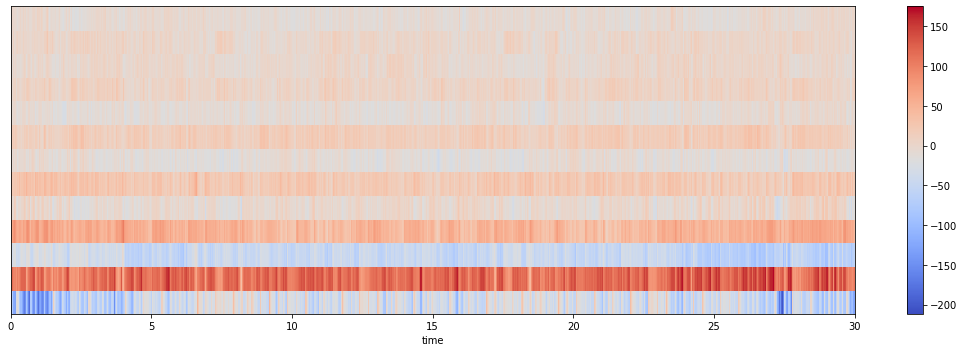

In [ ]:
plt.figure(figsize=(15,5))
librosa.display.specshow(mfcc_test, sr=sr_test1, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.xlabel('time')
plt.show()

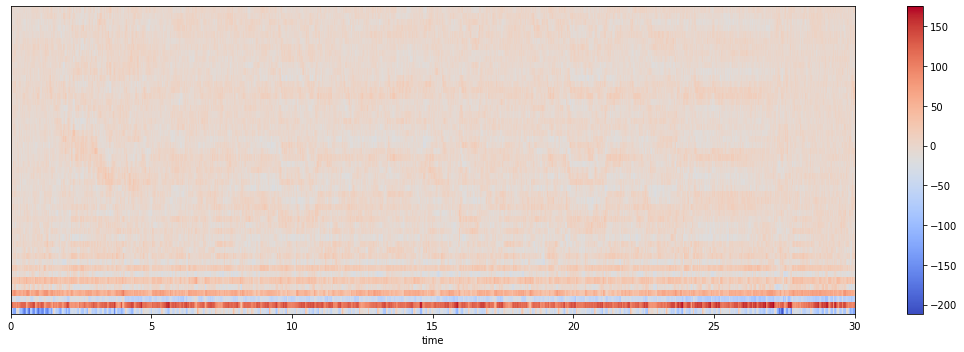

In [ ]:
mfcc_test = librosa.feature.mfcc(music_test1, sr=sr_test1, n_mfcc=50) # n_mfcc 50으로 설정

plt.figure(figsize=(15,5))
librosa.display.specshow(mfcc_test, sr=sr_test1, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.xlabel('time')
plt.show()

## MFCC 특성 추출

In [198]:
# 음원 특성 추출 함수 정의(v2)
def get_features_v2(df, duration=None, offset=0.0, start_idx=START_INDEX, end_idx=END_INDEX):
  df_copy = df.copy() # 데이터프레임 복사본 생성

  for idx, row in tqdm(df_copy.iterrows()):
    # index 범위 확인
    if idx < start_idx or idx > end_idx:
      continue

    # 음원 load
    music_path = row['Path']
    music, sr = librosa.load(music_path, sr=SAMPLING_RATE, duration=duration, offset=offset) # 옵션값 기준 구간 설정

    # mfcc 13개 차원별 평균 및 분산 산출 후 저장
    mfcc = librosa.feature.mfcc(music, sr=sr, n_mfcc=7) # n_mfcc 13으로 설정
    for i, values in enumerate(mfcc):
      df_copy.loc[idx, f'MFCC{i+1}_mean'] = values.mean() # 평균
      df_copy.loc[idx, f'MFCC{i+1}_var'] = values.var() # 분산
  
  return df_copy

#### 음원 특성 추출 결과 저장 => "df_total_v2"

In [199]:
df_total_v2 = get_features_v2(df_total_v1)

0it [00:00, ?it/s]

In [200]:
df_total_v2.head()

,Music,Path,Tempo,Chroma_stft1_mean,Chroma_stft1_var,Chroma_stft2_mean,Chroma_stft2_var,Chroma_stft3_mean,Chroma_stft3_var,Chroma_stft4_mean,Chroma_stft4_var,Chroma_stft5_mean,Chroma_stft5_var,Chroma_stft6_mean,Chroma_stft6_var,Chroma_stft7_mean,Chroma_stft7_var,Chroma_stft8_mean,Chroma_stft8_var,Chroma_stft9_mean,Chroma_stft9_var,Chroma_stft10_mean,Chroma_stft10_var,Chroma_stft11_mean,Chroma_stft11_var,Chroma_stft12_mean,Chroma_stft12_var,Chroma_cqt1_mean,Chroma_cqt1_var,Chroma_cqt2_mean,Chroma_cqt2_var,Chroma_cqt3_mean,Chroma_cqt3_var,Chroma_cqt4_mean,Chroma_cqt4_var,Chroma_cqt5_mean,Chroma_cqt5_var,Chroma_cqt6_mean,Chroma_cqt6_var,Chroma_cqt7_mean,...,Chroma_cqt12_mean,Chroma_cqt12_var,Chroma_cens1_mean,Chroma_cens1_var,Chroma_cens2_mean,Chroma_cens2_var,Chroma_cens3_mean,Chroma_cens3_var,Chroma_cens4_mean,Chroma_cens4_var,Chroma_cens5_mean,Chroma_cens5_var,Chroma_cens6_mean,Chroma_cens6_var,Chroma_cens7_mean,Chroma_cens7_var,Chroma_cens8_mean,Chroma_cens8_var,Chroma_cens9_mean,Chroma_cens9_var,Chroma_cens10_mean,Chroma_cens10_var,Chroma_cens11_mean,Chroma_cens11_var,Chroma_cens12_mean,Chroma_cens12_var,MFCC1_mean,MFCC1_var,MFCC2_mean,MFCC2_var,MFCC3_mean,MFCC3_var,MFCC4_mean,MFCC4_var,MFCC5_mean,MFCC5_var,MFCC6_mean,MFCC6_var,MFCC7_mean,MFCC7_var
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,93.963068,0.455629,0.091857,0.421035,0.069740,0.501934,0.095546,0.471786,0.095901,0.422948,0.077418,0.519904,0.103906,0.424737,0.072491,0.397458,0.079420,0.396315,0.075201,0.480287,0.078926,0.610189,0.101571,0.466969,0.066534,0.515204,0.076764,0.401413,0.048684,0.582404,0.081058,0.554251,0.088089,0.380095,0.043671,0.553827,0.073857,0.381136,...,0.376777,0.040850,0.281621,0.018584,0.200288,0.009001,0.321092,0.023422,0.302838,0.029530,0.186214,0.007784,0.312777,0.018942,0.197135,0.006399,0.271000,0.017986,0.210762,0.018934,0.254793,0.009485,0.330936,0.018623,0.189543,0.007481,-77.246422,5983.342773,112.695198,732.174988,-38.904037,439.681793,53.163002,363.205170,-3.157686,156.870117,24.070549,127.785011,-10.446261,104.507866
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,95.703125,0.385404,0.101627,0.345018,0.084830,0.338347,0.083915,0.373243,0.105011,0.357092,0.093823,0.320674,0.084240,0.305181,0.071329,0.380741,0.087481,0.513290,0.117372,0.490511,0.097662,0.467087,0.107167,0.419564,0.096385,0.561075,0.121495,0.531338,0.120026,0.430538,0.078338,0.473896,0.086555,0.339087,0.047981,0.350441,0.057806,0.322761,...,0.478669,0.087827,0.318101,0.031096,0.294483,0.033099,0.217415,0.018938,0.263781,0.034013,0.170267,0.016763,0.176275,0.020943,0.152241,0.014309,0.225735,0.018216,0.297125,0.028672,0.198238,0.030400,0.277522,0.019231,0.260278,0.022349,-125.237442,8046.360840,110.237984,1391.248535,10.074493,470.187622,31.458399,400.905182,-0.131919,307.428711,27.062531,203.955215,-12.667672,161.341553
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,101.332721,0.441707,0.092486,0.390669,0.076517,0.425990,0.094821,0.368770,0.069010,0.442873,0.099359,0.464066,0.102929,0.367889,0.062986,0.408600,0.099326,0.418237,0.080408,0.490182,0.110623,0.444174,0.096447,0.423160,0.077809,0.521200,0.100951,0.382445,0.053640,0.444765,0.069669,0.329762,0.036970,0.432361,0.054077,0.463744,0.048479,0.386621,...,0.392481,0.046048,0.275612,0.031757,0.188197,0.013879,0.242663,0.024967,0.145882,0.010859,0.239395,0.016687,0.271746,0.016500,0.192515,0.007026,0.293663,0.019678,0.280706,0.014708,0.342485,0.021357,0.307566,0.038814,0.194643,0.009192,-82.006393,6537.869629,115.500488,1254.196411,-24.530737,696.091980,48.868473,374.986664,-10.213676,343.135223,25.576668,257.841797,-4.791154,177.612274
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,105.468750,0.381196,0.096303,0.393144,0.091682,0.429483,0.105532,0.404150,0.094561,0.373291,0.086187,0.402523,0.094053,0.374840,0.074241,0.402259,0.101647,0.421317,0.090438,0.480019,0.113287,0.442668,0.106981,0.387265,0.093042,0.529438,0.065211,0.635517,0.068684,0.62

In [201]:
df_total_v2.shape

(64, 89)

In [202]:
df_total_v2.to_csv(DIR_PATH + 'test_data/df_total_v2.csv', index=False) # csv 파일로 저장

In [203]:
df_total_v2 = pd.read_csv(DIR_PATH + 'test_data/df_total_v2.csv') # csv 파일 불러오기
df_total_v2.shape

(64, 89)

In [204]:
df_total_v1.head(20) # 특성 추출 결과 확인

,Music,Path,Tempo,Chroma_stft1_mean,Chroma_stft1_var,Chroma_stft2_mean,Chroma_stft2_var,Chroma_stft3_mean,Chroma_stft3_var,Chroma_stft4_mean,Chroma_stft4_var,Chroma_stft5_mean,Chroma_stft5_var,Chroma_stft6_mean,Chroma_stft6_var,Chroma_stft7_mean,Chroma_stft7_var,Chroma_stft8_mean,Chroma_stft8_var,Chroma_stft9_mean,Chroma_stft9_var,Chroma_stft10_mean,Chroma_stft10_var,Chroma_stft11_mean,Chroma_stft11_var,Chroma_stft12_mean,Chroma_stft12_var,Chroma_cqt1_mean,Chroma_cqt1_var,Chroma_cqt2_mean,Chroma_cqt2_var,Chroma_cqt3_mean,Chroma_cqt3_var,Chroma_cqt4_mean,Chroma_cqt4_var,Chroma_cqt5_mean,Chroma_cqt5_var,Chroma_cqt6_mean,Chroma_cqt6_var,Chroma_cqt7_mean,Chroma_cqt7_var,Chroma_cqt8_mean,Chroma_cqt8_var,Chroma_cqt9_mean,Chroma_cqt9_var,Chroma_cqt10_mean,Chroma_cqt10_var,Chroma_cqt11_mean,Chroma_cqt11_var,Chroma_cqt12_mean,Chroma_cqt12_var,Chroma_cens1_mean,Chroma_cens1_var,Chroma_cens2_mean,Chroma_cens2_var,Chroma_cens3_mean,Chroma_cens3_var,Chroma_cens4_mean,Chroma_cens4_var,Chroma_cens5_mean,Chroma_cens5_var,Chroma_cens6_mean,Chroma_cens6_var,Chroma_cens7_mean,Chroma_cens7_var,Chroma_cens8_mean,Chroma_cens8_var,Chroma_cens9_mean,Chroma_cens9_var,Chroma_cens10_mean,Chroma_cens10_var,Chroma_cens11_mean,Chroma_cens11_var,Chroma_cens12_mean,Chroma_cens12_var
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,93.963068,0.455629,0.091857,0.421035,0.069740,0.501934,0.095546,0.471786,0.095901,0.422948,0.077418,0.519904,0.103906,0.424737,0.072491,0.397458,0.079420,0.396315,0.075201,0.480287,0.078926,0.610189,0.101571,0.466969,0.066534,0.515204,0.076764,0.401413,0.048684,0.582404,0.081058,0.554251,0.088089,0.380095,0.043671,0.553827,0.073857,0.381136,0.041231,0.499511,0.069588,0.420015,0.065681,0.463250,0.049916,0.582027,0.075694,0.376777,0.040850,0.281621,0.018584,0.200288,0.009001,0.321092,0.023422,0.302838,0.029530,0.186214,0.007784,0.312777,0.018942,0.197135,0.006399,0.271000,0.017986,0.210762,0.018934,0.254793,0.009485,0.330936,0.018623,0.189543,0.007481
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,95.703125,0.385404,0.101627,0.345018,0.084830,0.338347,0.083915,0.373243,0.105011,0.357092,0.093823,0.320674,0.084240,0.305181,0.071329,0.380741,0.087481,0.513290,0.117372,0.490511,0.097662,0.467087,0.107167,0.419564,0.096385,0.561075,0.121495,0.531338,0.120026,0.430538,0.078338,0.473896,0.086555,0.339087,0.047981,0.350441,0.057806,0.322761,0.047782,0.400804,0.060420,0.494855,0.077104,0.381062,0.064291,0.463533,0.064680,0.478669,0.087827,0.318101,0.031096,0.294483,0.033099,0.217415,0.018938,0.263781,0.034013,0.170267,0.016763,0.176275,0.020943,0.152241,0.014309,0.225735,0.018216,0.297125,0.028672,0.198238,0.030400,0.277522,0.019231,0.260278,0.022349
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,101.332721,0.441707,0.092486,0.390669,0.076517,0.425990,0.094821,0.368770,0.069010,0.442873,0.099359,0.464066,0.102929,0.367889,0.062986,0.408600,0.099326,0.418237,0.080408,0.490182,0.110623,0.444174,0.096447,0.423160,0.077809,0.521200,0.100951,0.382445,0.053640,0.444765,0.069669,0.329762,0.036970,0.432361,0.054077,0.463744,0.048479,0.386621,0.046854,0.537298,0.085569,0.526882,0.090841,0.604191,0.086772,0.573082,0.098441,0.392481,0.046048,0.275612,0.031757,0.188197,0.013879,0.242663,0.024967,0.145882,0.010859,0.239395,0.016687,0.271746,0.016500,0.192515,0.007026,0.293663,0.019678,0.280706,0.014708,0.342485,0.021357,0.307566,0.038814,0.194643,0.009192
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,105.468750,0.381196,0.096303,0.393144,0.091682,0.429483,0.105532,0.404150,0.094561,0.373291,0.086187,0.402523,0.094053,0.374840,0.074241,0.402259,0.101647,0.421317,0.090438,0.480019,0.113287,0.442668,0.106981,0.387265,0.093042,0.529438,0.065211,0.635517,0.068684,0.622463,0.074319,0.473457,0.049322,0.456608,0.044852,0.446284,0.051490,0.423495,0.036625,0.455113,0.048801,0.450094,0.040692,0.551862,0.058376,0.512806,0.077958,0.457088,0.053970,0.274985,0.015978,0.353138,0.016573,0.331165,0.020

#### 전체 컬럼 스케일링 => "df_total_v2_norm"

In [205]:
df_total_v2_norm = df_total_v2.copy()

mms = MinMaxScaler() # MinMax 스케일링
df_total_v2_norm.loc[:, 'Tempo':] = mms.fit_transform(df_total_v2_norm.loc[:, 'Tempo':])
df_total_v2_norm.head()

,Music,Path,Tempo,Chroma_stft1_mean,Chroma_stft1_var,Chroma_stft2_mean,Chroma_stft2_var,Chroma_stft3_mean,Chroma_stft3_var,Chroma_stft4_mean,Chroma_stft4_var,Chroma_stft5_mean,Chroma_stft5_var,Chroma_stft6_mean,Chroma_stft6_var,Chroma_stft7_mean,Chroma_stft7_var,Chroma_stft8_mean,Chroma_stft8_var,Chroma_stft9_mean,Chroma_stft9_var,Chroma_stft10_mean,Chroma_stft10_var,Chroma_stft11_mean,Chroma_stft11_var,Chroma_stft12_mean,Chroma_stft12_var,Chroma_cqt1_mean,Chroma_cqt1_var,Chroma_cqt2_mean,Chroma_cqt2_var,Chroma_cqt3_mean,Chroma_cqt3_var,Chroma_cqt4_mean,Chroma_cqt4_var,Chroma_cqt5_mean,Chroma_cqt5_var,Chroma_cqt6_mean,Chroma_cqt6_var,Chroma_cqt7_mean,...,Chroma_cqt12_mean,Chroma_cqt12_var,Chroma_cens1_mean,Chroma_cens1_var,Chroma_cens2_mean,Chroma_cens2_var,Chroma_cens3_mean,Chroma_cens3_var,Chroma_cens4_mean,Chroma_cens4_var,Chroma_cens5_mean,Chroma_cens5_var,Chroma_cens6_mean,Chroma_cens6_var,Chroma_cens7_mean,Chroma_cens7_var,Chroma_cens8_mean,Chroma_cens8_var,Chroma_cens9_mean,Chroma_cens9_var,Chroma_cens10_mean,Chroma_cens10_var,Chroma_cens11_mean,Chroma_cens11_var,Chroma_cens12_mean,Chroma_cens12_var,MFCC1_mean,MFCC1_var,MFCC2_mean,MFCC2_var,MFCC3_mean,MFCC3_var,MFCC4_mean,MFCC4_var,MFCC5_mean,MFCC5_var,MFCC6_mean,MFCC6_var,MFCC7_mean,MFCC7_var
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,0.192905,0.421281,0.415367,0.380265,0.402444,0.476700,0.572947,0.447382,0.703488,0.310613,0.372402,0.453759,0.594209,0.372396,0.442529,0.369713,0.530281,0.279140,0.468085,0.447555,0.531164,0.793805,0.756580,0.376956,0.326878,0.587361,0.544763,0.478357,0.262790,0.837391,0.480231,0.745533,0.600343,0.307764,0.239920,0.718389,0.456096,0.446248,...,0.460543,0.236236,0.640120,0.169552,0.477859,0.086904,0.601135,0.217226,0.842170,0.283194,0.213843,0.032046,0.719366,0.148919,0.338856,0.037767,0.368302,0.116549,0.313459,0.223983,0.299934,0.070529,0.656047,0.192682,0.327584,0.032869,0.914867,0.157197,0.409641,0.017527,0.019270,0.053321,0.709458,0.085449,0.406121,0.048545,0.710587,0.113838,0.192260,0.120424
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,0.209575,0.320208,0.489455,0.275666,0.550357,0.245199,0.487103,0.304512,0.783782,0.201100,0.486224,0.047244,0.434421,0.096444,0.430485,0.337057,0.605757,0.536522,0.807605,0.467152,0.677381,0.527717,0.807916,0.285650,0.626848,0.649409,0.878920,0.741395,0.805205,0.512402,0.460837,0.617715,0.589317,0.246320,0.279005,0.390667,0.346054,0.333616,...,0.662054,0.631729,0.726601,0.291265,0.756583,0.459296,0.351210,0.161862,0.728185,0.327819,0.182545,0.152647,0.371932,0.167993,0.220342,0.188854,0.268280,0.118689,0.560759,0.408837,0.191186,0.379169,0.533834,0.201195,0.532496,0.283003,0.757566,0.256188,0.392060,0.156072,0.415037,0.064814,0.444794,0.103500,0.450011,0.201326,0.770484,0.242722,0.143985,0.283079
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,0.263510,0.401243,0.420137,0.338481,0.468875,0.369227,0.567598,0.298028,0.466479,0.343746,0.524630,0.339825,0.586266,0.241182,0.343981,0.391479,0.716666,0.327375,0.510006,0.466521,0.778532,0.485114,0.709570,0.292576,0.440181,0.595471,0.725450,0.439957,0.300475,0.542849,0.399011,0.388446,0.233059,0.386076,0.334273,0.573235,0.282103,0.456831,...,0.491601,0.279998,0.625873,0.297691,0.442081,0.162290,0.412074,0.236304,0.384107,0.097322,0.318218,0.151627,0.614931,0.125630,0.326659,0.049745,0.418382,0.132299,0.513745,0.143779,0.468557,0.245722,0.602576,0.475023,0.342358,0.061643,0.899265,0.183805,0.429712,0.127262,0.135412,0.149922,0.657091,0.091090,0.303771,0.237559,0.740738,0.333901,0.315157,0.329645
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,0.303136,0.314152,0.449085,0.341887,0.617519,0.374171,0.646647,0.349322,0.691677,0.228039,0.433245,0.214251,0.514152,0.257225,0.460677,0.379092,0.738396,0.334151,0.590758,0.447041,0.799322,0.482313,0.806206,0.223442,0.593258,0.606614,0.458461,0.952311,0.414850,0.923117,0.432174,0.617017,0.321804,0.422407,0.250633,0.545102,0.302750,0.527978,...,0.619

## (df_total_v2_norm 기준) 음원별 유사도 측정 및 비교

#### Test음원과 유사음원간 비교 => "score_table_2a"

In [206]:
# "score_table_2a" 생성
score_table_2a = pd.read_excel(DIR_PATH + 'test_data/test_data_table.xlsx', index_col=0)

for idx, row in score_table_2a.iterrows():
  # 스케일링 적용된 데이터 기준 값 추출
  a = df_total_v2_norm.loc[idx*2-2,'Tempo':].values
  b = df_total_v2_norm.loc[idx*2-1,'Tempo':].values

  # 컬럼별 값 추가
  score_table_2a.loc[idx, 'Euclidean'] = euclidean_dist(a, b)
  score_table_2a.loc[idx, 'Cos_sim'] = cos_similarity(a, b)
  score_table_2a.loc[idx, 'Pearson_sim'] = pearson_similarity(a, b)

#### Test음원과 샘플음원(랜덤추출)간 비교 => "score_table_2b"

In [207]:
# "score_table_2b" 생성
score_table_2b = pd.read_excel(DIR_PATH + 'test_data/test_data_table.xlsx', index_col=0)
score_table_2b.drop(['구분'], axis=1, inplace=True)
score_table_2b['비교곡'] = f'샘플 Music {SAMPLE_MUSIC}곡'

for idx, row in score_table_2b.iterrows():
  # 스케일링 적용된 데이터 기준 추출
  a = df_total_v2_norm.loc[idx*2-2,'Tempo':].values

  # 샘플 Music들과 각각 비교 후 평균값 산출
  euclidean_dist_list = []
  cos_similarity_list = []
  pearson_similarity_list = []
  for i in range(SAMPLE_MUSIC):
    samplt_idx = df_total_v2_norm.index[i+14] # Test 데이터 개수(14)만큼 조정
    b = df_total_v2_norm.loc[samplt_idx,'Tempo':].values

    euclidean_dist_list.append(euclidean_dist(a, b))
    cos_similarity_list.append(cos_similarity(a, b))
    pearson_similarity_list.append(pearson_similarity(a, b))

  # 컬럼별 값 추가
  score_table_2b.loc[idx, 'Euclidean'] = np.mean(euclidean_dist_list)
  score_table_2b.loc[idx, 'Cos_sim'] = np.mean(cos_similarity_list)
  score_table_2b.loc[idx, 'Pearson_sim'] = np.mean(pearson_similarity_list)

In [208]:
score_table_2a

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,1.750802,0.916216,0.622149
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,1.387200,0.946358,0.763546
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,1.270704,0.951218,0.681589
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,2.097832,0.884701,0.478148
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,1.456106,0.949991,0.794496
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,1.652299,0.928950,0.547759
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,0.900323,0.977385,0.904035


In [209]:
score_table_2b

,원곡,비교곡,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,샘플 Music 50곡,2.623539,0.812549,0.241578
2,와이낫 - 파랑새,샘플 Music 50곡,2.501897,0.829346,0.207561
3,요시마타 료 - Resolver,샘플 Music 50곡,2.340249,0.846718,0.232468
4,TLC - No Scrubs,샘플 Music 50곡,2.732163,0.806532,0.180183
5,Harold Faltermeyer - Axel F,샘플 Music 50곡,2.680168,0.822576,0.236772
6,A$ton Wyld - Next Level,샘플 Music 50곡,2.504139,0.836822,0.212848
7,S.E.S. - Dreams Come True,샘플 Music 50곡,2.698286,0.804167,0.212592


#### score_table_2a, score_table_2b 결과 비교

In [210]:
score_table_result_2b = score_table_2a.copy()

# Euclidean 점수 => 샘플음원 대비 유사음원과 비교 시, (-) 변화량 비율(%)
score_table_result_2b['Euclidean'] = round(((score_table_2b['Euclidean'] - score_table_result_2b['Euclidean']) / score_table_2b['Euclidean']) * 100, 2)

# Cos_sim 점수 => 샘플음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)
score_table_result_2b['Cos_sim'] = round(((score_table_result_2b['Cos_sim'] - score_table_2b['Cos_sim']) / score_table_2b['Cos_sim']) * 100, 2)

# Pearson_sim 점수 => 샘플음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)
score_table_result_2b['Pearson_sim'] = round(((score_table_result_2b['Pearson_sim'] - score_table_2b['Pearson_sim']) / score_table_2b['Pearson_sim']) * 100, 2)

# Score 산출 => 3개 점수의 평균
score_table_result_2b["Score"] = round((score_table_result_2b['Euclidean'] + score_table_result_2b['Cos_sim'] + score_table_result_2b['Pearson_sim']) / 3, 2)

score_table_result_2b # 결과 확인

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim,Score
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,33.27,12.76,157.54,67.86
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,44.55,14.11,267.87,108.84
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,45.70,12.34,193.20,83.75
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,23.22,9.69,165.37,66.09
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,45.67,15.49,235.55,98.90
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,34.02,11.01,157.35,67.46
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,66.63,21.54,325.24,137.80


In [211]:
score_table_result_2b["Score"].mean() # Score 평균 확인

90.1

#### Test음원과 Test음원(12곡)간 비교 => "score_table_2c"

In [212]:
# "score_table_2c" 생성
score_table_2c = pd.read_excel(DIR_PATH + 'test_data/test_data_table.xlsx', index_col=0)
score_table_2c.drop(['구분'], axis=1, inplace=True)
score_table_2c['비교곡'] = f'다른 Test음원 12곡'

for idx, row in score_table_2c.iterrows():
  # 스케일링 적용된 데이터 기준 추출
  a = df_total_v2_norm.loc[idx*2-2,'Tempo':].values

  # Test음원(12곡)들과 각각 비교 후 평균값 산출
  euclidean_dist_list = []
  cos_similarity_list = []
  pearson_similarity_list = []
  for i in range(12):
    samplt_idx = df_total_v2_norm.index[(idx*2+i)%14] # Test 음원(14곡) 중 유사음원이 아닌 12곡과 비교
    b = df_total_v2_norm.loc[samplt_idx,'Tempo':].values

    euclidean_dist_list.append(euclidean_dist(a, b))
    cos_similarity_list.append(cos_similarity(a, b))
    pearson_similarity_list.append(pearson_similarity(a, b))

  # 컬럼별 값 추가
  score_table_2c.loc[idx, 'Euclidean'] = np.mean(euclidean_dist_list)
  score_table_2c.loc[idx, 'Cos_sim'] = np.mean(cos_similarity_list)
  score_table_2c.loc[idx, 'Pearson_sim'] = np.mean(pearson_similarity_list)

In [213]:
score_table_2c

,원곡,비교곡,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,다른 Test음원 12곡,1.673574,0.920994,0.645134
2,와이낫 - 파랑새,다른 Test음원 12곡,1.640317,0.923630,0.596875
3,요시마타 료 - Resolver,다른 Test음원 12곡,1.868972,0.901721,0.458132
4,TLC - No Scrubs,다른 Test음원 12곡,1.888770,0.906459,0.552400
5,Harold Faltermeyer - Axel F,다른 Test음원 12곡,2.077860,0.893945,0.479779
6,A$ton Wyld - Next Level,다른 Test음원 12곡,1.945963,0.901016,0.468419
7,S.E.S. - Dreams Come True,다른 Test음원 12곡,1.764062,0.913391,0.610975


In [214]:
score_table_result_2c = score_table_2a.copy()

# Euclidean 점수 => 샘플음원 대비 유사음원과 비교 시, (-) 변화량 비율(%)
score_table_result_2c['Euclidean'] = round(((score_table_2c['Euclidean'] - score_table_result_2c['Euclidean']) / score_table_2c['Euclidean']) * 100, 2)

# Cos_sim 점수 => 샘플음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)
score_table_result_2c['Cos_sim'] = round(((score_table_result_2c['Cos_sim'] - score_table_2c['Cos_sim']) / score_table_2c['Cos_sim']) * 100, 2)

# Pearson_sim 점수 => 샘플음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)
score_table_result_2c['Pearson_sim'] = round(((score_table_result_2c['Pearson_sim'] - score_table_2c['Pearson_sim']) / score_table_2c['Pearson_sim']) * 100, 2)

# Score 산출 => 3개 점수의 평균
score_table_result_2c["Score"] = round((score_table_result_2c['Euclidean'] + score_table_result_2c['Cos_sim'] + score_table_result_2c['Pearson_sim']) / 3, 2)

score_table_result_2c # 결과 확인

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim,Score
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,-4.61,-0.52,-3.56,-2.90
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,15.43,2.46,27.92,15.27
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,32.01,5.49,48.78,28.76
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,-11.07,-2.40,-13.44,-8.97
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,29.92,6.27,65.60,33.93
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,15.09,3.10,16.94,11.71
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,48.96,7.01,47.97,34.65


In [215]:
score_table_result_2c["Score"].mean() # Score 평균 확인

16.064285714285717

#### (참고) 코사인 유사도 산출 시, 정규화 필요성 검토

In [216]:
test1 = np.array([0.5, 0.7, 0.9, 0.1])
test2 = np.array([0.2, 0.9, 0.3, 0.5])

cos_similarity(test1, test2)

0.7706434991063845

In [217]:
test1 = np.array([0.5, 0.7, 0.9, 0.1])
test2 = np.array([0.3, 0.8, 0.5, 0.3])

cos_similarity(test1, test2)

0.9210702887810189

In [218]:
test1 = np.array([0.5, 0.7, 0.9, 0.1, 10000])
test2 = np.array([0.1, 0.2, 0.3, 0.9, 15000])

cos_similarity(test1, test2)

0.9999999937555558

In [219]:
test1 = np.array([0.5, 0.7, 0.9, 0.1, 0.1])
test2 = np.array([0.1, 0.2, 0.3, 0.9, 0.15])

cos_similarity(test1, test2)

0.4572501078836351

In [220]:
# melspectrogram 시각화 함수 정의
def show_melspectrogram(music, sr):
  S = librosa.feature.melspectrogram(y=music, sr=sr)
  S_db = librosa.power_to_db(S, ref=np.max)
  seconds = len(music)/SAMPLING_RATE

  plt.figure(figsize=(15,5))
  librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
  plt.colorbar()
  plt.tight_layout()
  plt.xlabel('time')
  plt.ylabel('Hz')
  plt.xticks(np.arange(0, seconds, seconds//10)) # 좌표간격 설정
  plt.show()

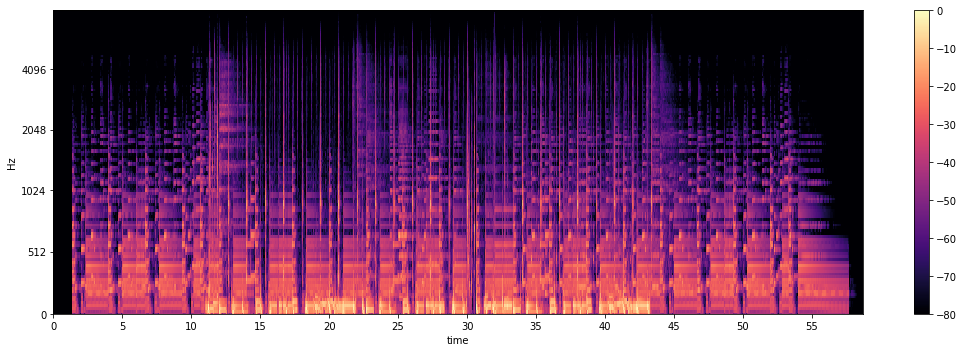

In [221]:
show_melspectrogram(music, sr)

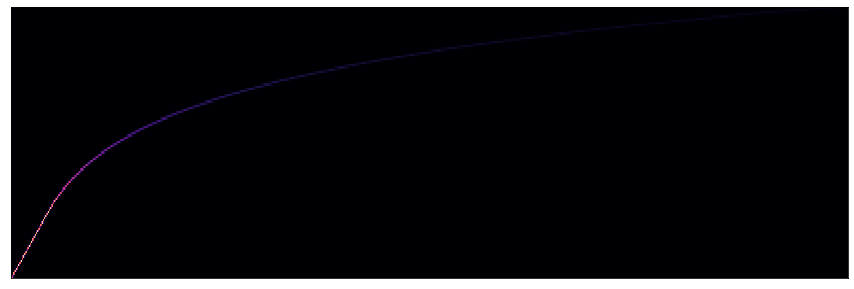

In [222]:
plt.figure(figsize=(15,5))
librosa.display.specshow(librosa.filters.mel(SAMPLING_RATE, n_fft=2048))
plt.show()

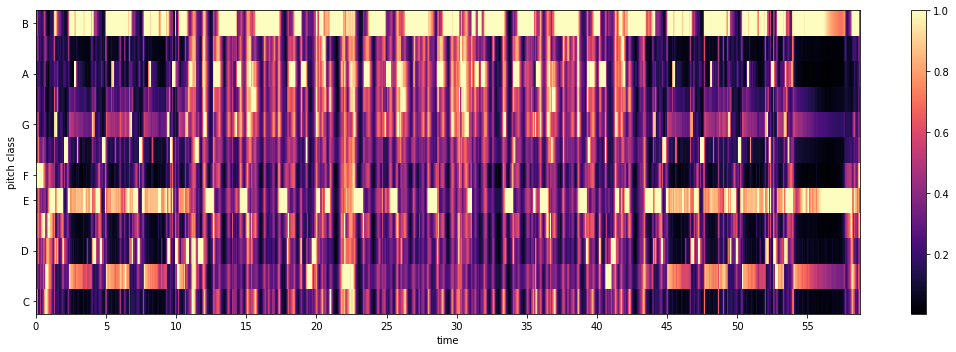

In [223]:
show_chromagram(music, sr, 'cqt')

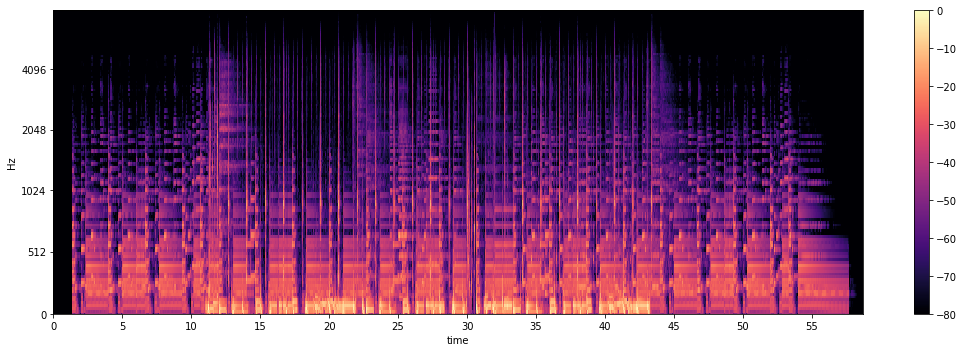

In [224]:
show_melspectrogram(music, sr)

In [225]:
hop_length = 512
n_fft = 2048

chroma2 = librosa.stft(music, n_fft=n_fft, hop_length=hop_length)

magnitude = np.abs(chroma2)

log_spectrogram = librosa.amplitude_to_db(magnitude, ref=np.max)

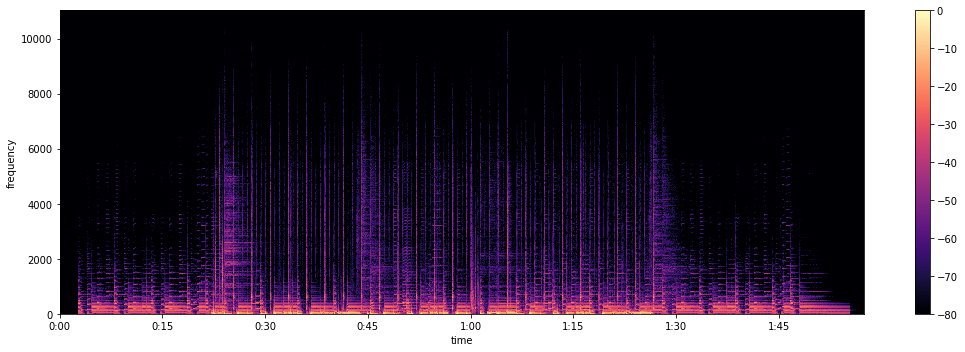

In [226]:
plt.figure(figsize=(15,5))
librosa.display.specshow(log_spectrogram, x_axis='time', y_axis='hz')
plt.colorbar()
plt.tight_layout()
plt.xlabel('time')
plt.ylabel('frequency')
plt.show()